### Analyze Post-Optimization results for a single run

In [1]:
# Import python modules
import os
import sys
import pandas as pd
import numpy as np

# Determine the absolute path to the src directory (one level up from notebooks)
module_path = os.path.abspath(os.path.join("..", "src"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Import custom modules
import plotting
import utils

In [5]:
SAVE_FIGURES = False
SAVE_TABLES = False

In [6]:
FOLDER = os.path.join(
    os.path.dirname(os.getcwd()),
    "runs",
    "single_runs",
    "GTSEP_v1-No name-Feb17_Mon_h11",
)
decision_variables_folder = os.path.join(FOLDER, "decision_variables")
model_info_folder = os.path.join(FOLDER, "model_info")

In [7]:
results_folder = os.path.join(FOLDER, "results")
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
if SAVE_TABLES:
    tables_folder = os.path.join(results_folder, "tables")
    if not os.path.exists(tables_folder):
        os.makedirs(tables_folder)
else:
    tables_folder = None
if SAVE_FIGURES:
    figures_folder = os.path.join(results_folder, "figures")
    if not os.path.exists(figures_folder):
        os.makedirs(figures_folder)

In [8]:
# Print all files in the folder
def print_files(folder):
    for root, dirs, files in os.walk(folder):
        for file in files:
            print(file)


print_files(decision_variables_folder)

battery_build.csv
battery_charging.csv
battery_discharging.csv
battery_soc.csv
branch_build.csv
branch_capacity.csv
curtailment.csv
generation.csv
generator_build.csv
generator_capacity.csv
load_shedding.csv
power_flow.csv


In [11]:
data = utils.load_csv_files_from_folder(decision_variables_folder)

In [10]:
model_info = pd.read_csv(os.path.join(model_info_folder, "model_info.csv"), index_col=0)
model_info

,Optimality Gap (%),Runtime (s),Build Time (s),Optimize Time (s),Total Time (s),Number of Variables,Number of Constraints,Number of Nonzeros,Model Status
Objective Value,,,,,,,,,
1.237373e+10,0.000284,6.293,27.402521,6.428374,33.830895,297856,332889,840964,2


In [11]:
import yaml

model_config = yaml.safe_load(open(os.path.join(model_info_folder, "config.yaml")))
model_config

{'CC': 100,
 'CO2_price': 85,
 'E_limit': inf,
 'MIPGap': 0.01,
 'MS': 0.1,
 'VOLL': '6.35e3',
 'data_folder_name': 'elec_s_37_ES_PT',
 'expansion_factor': 2.0,
 'model_id': 'test small',
 'model_name': 'GTSEP_v0',
 'p_max_new_branch': 3000,
 'p_min_new_branch': 100,
 'run_id': 'GTSEP_v0-test small-Feb11_Tue_h10',
 'save_folder': 'C:\\Users\\tinus\\OneDrive\\Dokumenter\\0 Master\\code\\master_project\\runs\\single_runs\\GTSEP_v0-test small-Feb11_Tue_h10'}

In [12]:
input_data_folder_name = model_config["data_folder_name"]
input_data_folder = os.path.join(
    os.path.dirname(os.getcwd()), "data", "processed", input_data_folder_name
)
print(input_data_folder)

c:\Users\tinus\OneDrive\Dokumenter\0 Master\code\master_project\data\processed\elec_s_37_ES_PT


In [13]:
RESULTS_FOLDER = os.path.join(FOLDER, "results")
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [14]:
battery_build = data["battery_build"]
battery_charging = data["battery_charging"]
battery_discharging = data["battery_discharging"]
battery_soc = data["battery_soc"]
branch_build = data["branch_build"]
branch_capacity = data["branch_capacity"]
curtailment = data["curtailment"]
generation = data["generation"]
generator_build = data["generator_build"]
generator_capacity = data["generator_capacity"]
load_shedding = data["load_shedding"]
power_flow = data["power_flow"]

In [15]:
input_data = load_csv_files_to_dict(input_data_folder)
input_data.keys()

dict_keys(['batteries', 'branches', 'capacity_factors', 'generators', 'generator_costs', 'hourly_demand', 'nodes'])

In [16]:
batteries = input_data["batteries"]
branches = input_data["branches"]
generators = input_data["generators"]
capacity_factors = input_data["capacity_factors"]
generator_costs = input_data["generator_costs"]
hourly_demand = input_data["hourly_demand"]
nodes = input_data["nodes"]

In [17]:
# Create new branches
# Add a new column 'exists' to the original branches dataframe and set it to 1
branches["exists"] = 1
# Create a copy of the dataframe for the "new" branches
branches_new = branches.copy()
# Update the index by appending " new" to the original index
branches_new.index = branches_new.index.astype(str) + " new"
# Set the 'exists' column to 0 for the new branches
branches_new["exists"] = 0
# Concatenate the original dataframe and the new dataframe
branches = pd.concat([branches, branches_new])
branches["new"] = branches.index.astype(str).str.endswith("new").astype(int)
# Add a new column 'exists' to the original dataframe and set it to 1
generators["exists"] = 1
# Create a copy of the dataframe for the "new" generators
generators_new = generators.copy()
# Update the index by appending " new" to the original index
generators_new.index = generators_new.index + " new"
# Set the 'exists' column to 0 for the new generators
generators_new["exists"] = 0
# Concatenate the original dataframe and the new dataframe
generators = pd.concat([generators, generators_new])
batteries["exists"] = 0
generators["new"] = generators.index.str.endswith("new").astype(int)

In [22]:
# Make sure a generator is built if its new capacity is 0
new_generators = pd.merge(
    generator_build, generator_capacity, left_index=True, right_index=True
)
# rename columns
column_names = ["built", "capacity"]
new_generators.columns = column_names
# Update 'built' to 0 where 'capacity' is 0
new_generators.loc[new_generators["capacity"] == 0, "built"] = 0
generators.loc[generator_build.index.values, "exists"] = new_generators["built"]
generators["new_capacity"] = 0.0
generators.loc[generator_capacity.index.values, "new_capacity"] = new_generators[
    "capacity"
]

built_generators_by_carrier = (
    generators[(generators["new"] == 1) & (generators["exists"] == 1)]
    .groupby("carrier")
    .size()
)
potential_generators_by_carrier_new = (
    generators[generators["new"] == 1].groupby("carrier").size()
)
capacity_by_carrier_new = (
    generators[(generators["new"] == 1) & (generators["exists"] == 1)]
    .groupby("carrier")["new_capacity"]
    .sum()
)


for carrier in generators["carrier"].unique():
    if carrier not in capacity_by_carrier_new.index:
        capacity_by_carrier_new[carrier] = 0.0

capacity_by_carrier_old = (
    generators[(generators["new"] == 0) & (generators["exists"] == 1)]
    .groupby("carrier")["p_nom"]
    .sum()
)


capacity_by_carrier_total = capacity_by_carrier_old + capacity_by_carrier_new
generators["potential_capacity"] = (
    generators["p_nom"] * model_config["expansion_factor"]
)

# Group by carrier and calculate the sum of potential_capacity
potential_capacity_by_carrier_new = (
    generators[generators["new"] == 1].groupby("carrier")["potential_capacity"].sum()
)
potential_capacity_by_carrier_old = (
    generators[generators["new"] == 0].groupby("carrier")["potential_capacity"].sum()
)
potential_capacity_by_carrier_total = (
    generators[generators["exists"] == 1].groupby("carrier")["potential_capacity"].sum()
)
combined_df = pd.concat(
    [
        built_generators_by_carrier.rename("Built Generators"),
        potential_generators_by_carrier_new.rename("Potential Generators"),
        capacity_by_carrier_new.rename("Capacity"),
        potential_capacity_by_carrier_new.rename("Potential Capacity"),
    ],
    axis=1,
)

# Display the combined dataframe
combined_df

,Built Generators,Potential Generators,Capacity,Potential Capacity
carrier,,,,
CCGT,2.0,2,12398.922259,60900.664000
solar,2.0,2,25414.038546,25414.038546
onwind,NaN,2,0.000000,64079.006689


In [23]:
# Filter the generators dataframe to include only existing generators
existing_generators = generators[generators["exists"] == 1]

# Calculate total actual production for each carrier type
total_production_by_carrier = {}

for carrier in existing_generators["carrier"].unique():
    # Select columns from the generation dataframe that match the carrier
    carrier_columns = [
        col
        for col in generation.columns[:-1]
        if col.endswith(carrier) or col.split(" ")[-2].endswith(carrier)
    ]
    # Sum the production for all generators of the carrier type
    total_production_by_carrier[carrier] = generation[carrier_columns].sum().sum()

# Convert the production dictionary to a pandas Series
total_production_by_carrier = pd.Series(
    total_production_by_carrier, name="total_production"
)

# Calculate the utilization rate for each carrier
# Multiply capacity by 8760 (hours in a year) to get the maximum possible production
utilization_rate = (
    total_production_by_carrier / (capacity_by_carrier_total * 8760)
) * 100

# Display the utilization rate as a percentage
utilization_rate = utilization_rate.rename("utilization_rate (%)")

In [24]:
# Calculate theoretical max utilization
max_utilization_rates = {}
for carrier in generators["carrier"].unique():
    columns = [gen for gen in capacity_factors.columns if carrier in gen]
    max_production_existing = (
        capacity_factors[columns].mean() * generators.loc[columns, "p_nom"]
    ).sum()
    max_production_wo_capacity_factor_existing = generators.loc[columns, "p_nom"].sum()
    new_columns = [col + " new" for col in columns]
    max_production_new = (
        capacity_factors[columns].mean().values
        * generators.loc[new_columns, "new_capacity"].values
    ).sum()
    max_production_wo_capacity_factor_new = generators.loc[
        new_columns, "new_capacity"
    ].sum()
    total_max_production = max_production_existing + max_production_new
    total_max_production_wo_capacity_factor = (
        max_production_wo_capacity_factor_existing
        + max_production_wo_capacity_factor_new
    )
    max_utilization_rates[carrier] = (
        total_max_production / total_max_production_wo_capacity_factor
    )

    # convert to series
max_utilization_rates = pd.Series(max_utilization_rates, name="max_utilization_rate")
utilization_rate_df = pd.concat([utilization_rate, max_utilization_rates], axis=1)
utilization_rate_df["max_utilization_rate"] = (
    utilization_rate_df["max_utilization_rate"] * 100
)
utilization_rate_df.columns = ["Utilization rate (%)", "Max utilization rate (%)"]
utilization_rate_df.round(2)

,Utilization rate (%),Max utilization rate (%)
CCGT,47.81,100.00
onwind,18.40,18.49
solar,16.41,17.33


In [25]:
generators_results = pd.concat([combined_df, utilization_rate_df], axis=1)
generators_results.round(2)

,Built Generators,Potential Generators,Capacity,Potential Capacity,Utilization rate (%),Max utilization rate (%)
CCGT,2.0,2,12398.92,60900.66,47.81,100.00
solar,2.0,2,25414.04,25414.04,16.41,17.33
onwind,NaN,2,0.00,64079.01,18.40,18.49


In [26]:
generators["capacity_factor"] = np.zeros(generators.shape[0])
for generator in generators.index:
    if generator in capacity_factors.columns:
        generators.loc[generator, "capacity_factor"] = capacity_factors[
            generator
        ].mean()
    else:
        generators.loc[generator, "capacity_factor"] = 1
generators["effective_capacity"] = generators["p_nom"] * generators["capacity_factor"]
weighted_capacity_factor = (
    generators.groupby("carrier")["effective_capacity"].sum()
    / generators.groupby("carrier")["p_nom"].sum()
)
weighted_capacity_factor

carrier
CCGT      1.000000
onwind    0.592462
solar     0.586638
dtype: float64

Generators by city and type effective capacity in GW


<Figure size 1800x900 with 0 Axes>

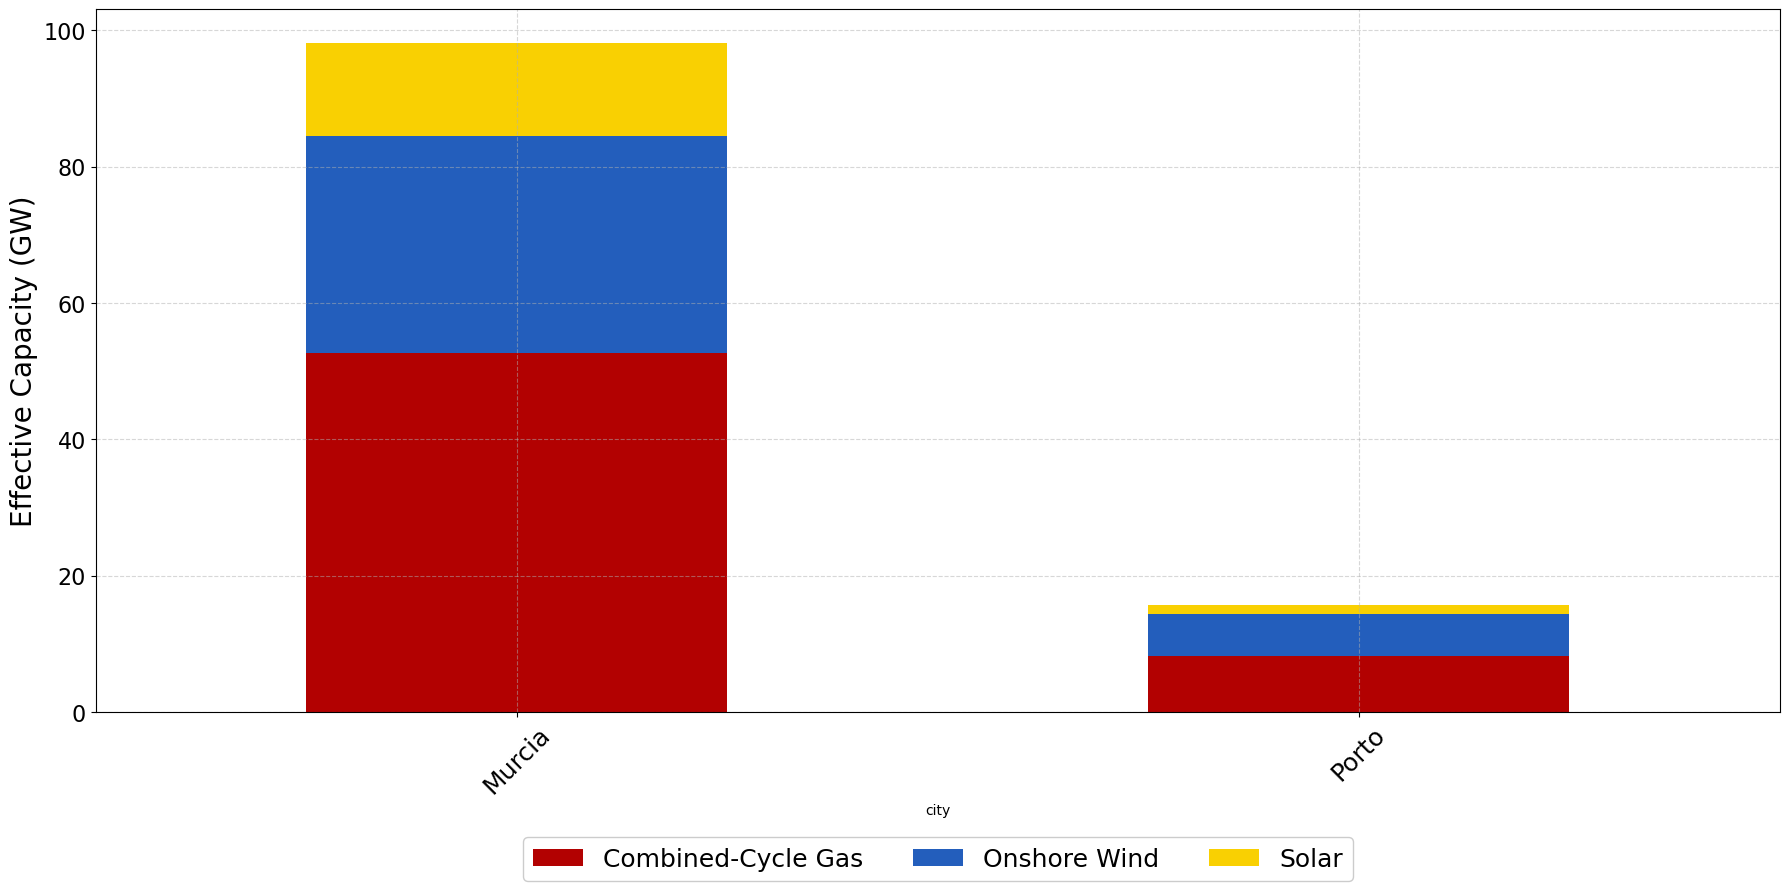

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# DataFrame `generators` and `node_to_city` mapping (assuming they're already defined)

# Add a 'city' column to the generators DataFrame based on the 'bus' mapping
generators["city"] = generators["bus"].map(plotting.node_to_city)

# Convert effective_capacity from MW to GW
generators["effective_capacity_gw"] = generators["effective_capacity"] / 1000

# Define the desired order for generator types
generator_order = ["CCGT", "coal", "offwind-ac", "onwind", "solar", "ror"]
generator_order = [
    gen for gen in generator_order if gen in generators["carrier"].unique()
]

# Create a mapping of carriers to their colors and nice names
carrier_colors = (
    generators.drop_duplicates("carrier").set_index("carrier")["color"].to_dict()
)
carrier_nice_names = (
    generators.drop_duplicates("carrier").set_index("carrier")["nice_name"].to_dict()
)

# Group by city and carrier, summing the effective capacity (effective_capacity_gw)
city_generator_effective_capacity = (
    generators.groupby(["city", "carrier"])["effective_capacity_gw"]
    .sum()
    .unstack(fill_value=0)
)

# Reorder the columns based on the specified generator order
city_generator_effective_capacity = city_generator_effective_capacity[generator_order]

# Plot the stacked bar chart
plt.figure(figsize=(18, 9))
city_generator_effective_capacity.plot(
    kind="bar",
    stacked=True,
    color=[
        carrier_colors[carrier] for carrier in city_generator_effective_capacity.columns
    ],
    figsize=(18, 9),
)

# Customize the plot appearance
plt.ylabel("Effective Capacity (GW)", fontsize=20)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=16)
plt.legend(
    [
        carrier_nice_names[carrier]
        for carrier in city_generator_effective_capacity.columns
    ],
    loc="upper center",
    fontsize=18,
    framealpha=1,
    bbox_to_anchor=(0.5, -0.16),
    ncol=len(generator_order),
)
plt.tight_layout()
print("Generators by city and type effective capacity in GW")
plt.grid(True, linestyle="--", alpha=0.5)
# Save the plot
# savepath = None  # Set to your desired save path, e.g., savepath = "figures/effective_capacity_by_city.png"
# savepath = os.path.join(FIGURE_FOLDER, "effective_capacity_by_city.png")
# if savepath:
#     plt.savefig(savepath, bbox_inches="tight")

# Show the plot
plt.show()

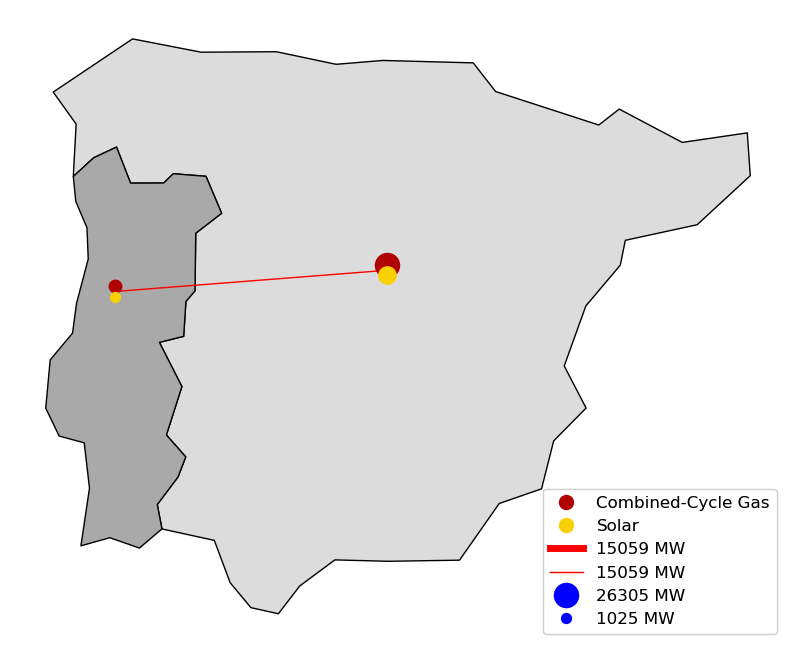

Plotting grid sized generators and lines


In [28]:
plotting.plot_sized_generators_and_lines(
    nodes,
    branches[branches["exists"] == 1],
    generators[(generators["new"] == 1) & (generators["exists"] == 1)],
)

### Plot production by month

Monthly Production by Carrier


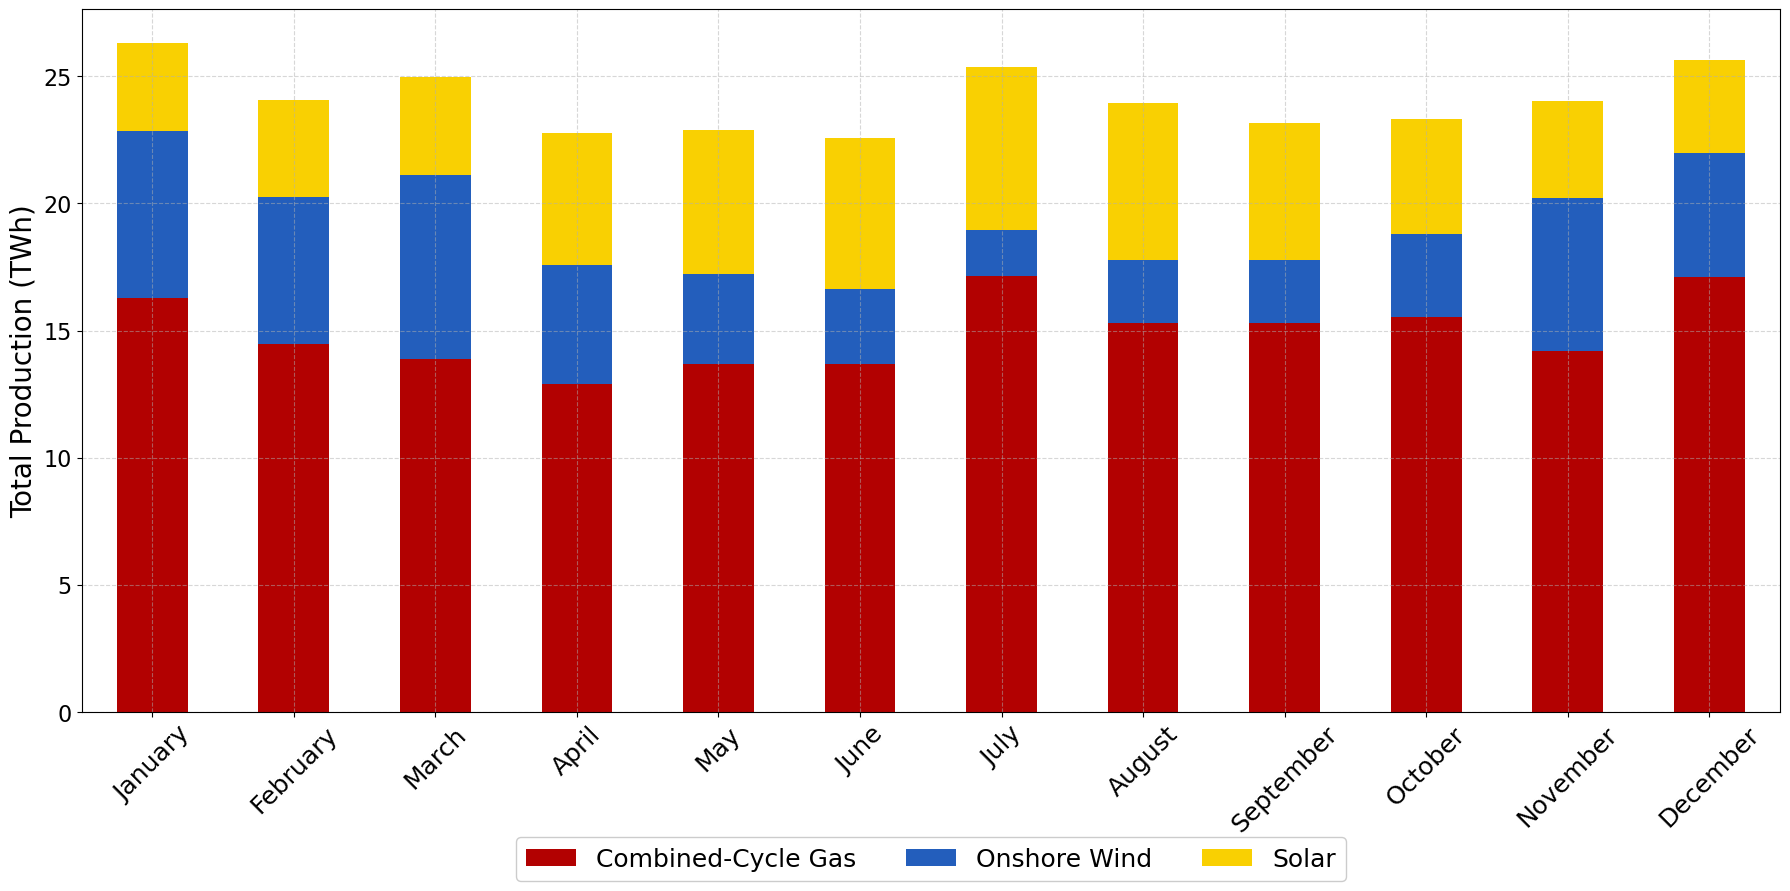

In [29]:
plotting.plot_monthly_production(generators, generation)

## Branches analysis

In [30]:
branches["new"] = [
    1 if new == True else 0 for new in branches.index.str.endswith("new")
]
# Ensure the indices of branches_build and branches match
branch_build = branch_build.rename_axis("Branch")

In [31]:
# Make sure a branch is built if its new capacity is 0
new_branches = pd.merge(
    branch_build, branch_capacity, left_index=True, right_index=True
)
# rename columns
column_names = ["built", "capacity"]
new_branches.columns = column_names
# Update 'built' to 0 where 'capacity' is 0
new_branches.loc[new_branches["capacity"] == 0, "built"] = 0

In [32]:
branches.loc[branch_build.index.values, "exists"] = new_branches["built"]
branches["new_capacity"] = 0.0
branches.loc[branch_capacity.index.values, "new_capacity"] = new_branches["capacity"]

In [33]:
num_new_branches_built = sum(branches[branches["new"] == 1]["exists"])
total_capacity_built = sum(
    branches[(branches["new"] == 1) & (branches["exists"] == 1)]["new_capacity"]
)
print(f"Number of new branches built: {num_new_branches_built}")
print(f"Total capacity of new branches built: {total_capacity_built:.2f}")

Number of new branches built: 0
Total capacity of new branches built: 0.00


In [34]:
branch_capacity_old_branches = branches[branches["new"] == 0]["p_max"].sum()
branch_capacity_new_branches = branches[branches["new"] == 1]["new_capacity"].sum()
existing_branch_ids = branches[branches["new"] == 0].index.astype(str)
new_branch_ids = branches[branches["new"] == 1].index.astype(str)
average_used_capacity_old_branches = (
    power_flow.loc[:, existing_branch_ids].abs().mean(axis=0)
)
average_used_capacity_new_branches = (
    power_flow.loc[:, new_branch_ids].abs().mean(axis=0)
)
print(
    f"Utilization of old branches: {sum(average_used_capacity_old_branches) / branch_capacity_old_branches * 100:.2f} %"
)
if branch_capacity_new_branches > 0:
    print(
        f"Utilization of new branches: {sum(average_used_capacity_new_branches) / branch_capacity_new_branches * 100:.2f} %"
    )

Utilization of old branches: 49.81 %


In [35]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from geopy.distance import geodesic
from matplotlib.collections import LineCollection
import matplotlib.lines as mlines


def plot_base_network(buses, branches, savepath=None):
    """Plots the base network with buses and transmission lines, without generators."""

    # Convert buses DataFrame to a GeoDataFrame
    geometry_buses = gpd.points_from_xy(buses["x"], buses["y"])
    gdf_buses = gpd.GeoDataFrame(buses, geometry=geometry_buses, crs="EPSG:4326")

    # Create a dictionary to map bus IDs to their coordinates for easy access
    bus_coords = gdf_buses[["x", "y"]].to_dict("index")

    # Generate list of line segments for LineCollection based on bus coordinates
    lines = []
    line_widths = []
    max_capacity = branches["new_capacity"].max()
    min_capacity = branches["new_capacity"].min()
    min_line_width = 1
    max_line_width = 5

    for _, row in branches.iterrows():
        if row["bus0"] in bus_coords and row["bus1"] in bus_coords:
            point0 = (bus_coords[row["bus0"]]["x"], bus_coords[row["bus0"]]["y"])
            point1 = (bus_coords[row["bus1"]]["x"], bus_coords[row["bus1"]]["y"])
            lines.append([point0, point1])

            # Normalize new_capacity between min_line_width and max_line_width
            linewidth = min_line_width + (row["new_capacity"] - min_capacity) / (
                max_capacity - min_capacity
            ) * (max_line_width - min_line_width)
            line_widths.append(linewidth)
        else:
            print(f"Excluded line with missing bus coordinates: {row}")

    # Load the Iberian map shapefile
    world = gpd.read_file(
        r"c:\\Users\\tinus\\OneDrive\\Dokumenter\\0 Master\\code\\specialization_project\\market_clearing_quick\\data\\countries\\ne_110m_admin_0_countries.shp"
    )
    spain = world[world["NAME"] == "Spain"]
    portugal = world[world["NAME"] == "Portugal"]

    # Plot the map and initialize the figure
    fig, ax = plt.subplots(figsize=(10, 10))
    spain.plot(ax=ax, color="gainsboro", edgecolor="black")
    portugal.plot(ax=ax, color="darkgrey", edgecolor="black")

    # Create and plot the LineCollection for transmission lines
    lc = LineCollection(lines, colors="red", linewidths=line_widths, zorder=15)
    ax.add_collection(lc)

    # Plot buses
    gdf_buses.plot(
        ax=ax, color="black", marker="o", markersize=50, zorder=20
    )  # No legend entry for buses

    # Create legend entries for line capacities
    max_capacity_label = f"{max_capacity:.0f} MW"
    min_capacity_label = f"{min_capacity:.0f} MW"

    # Custom legend items for max and min capacities
    max_line = mlines.Line2D(
        [], [], color="red", linewidth=max_line_width, label=max_capacity_label
    )
    min_line = mlines.Line2D(
        [], [], color="red", linewidth=min_line_width, label=min_capacity_label
    )
    bus_legend = mlines.Line2D(
        [],
        [],
        color="black",
        marker="o",
        linestyle="None",
        markersize=10,
        label="Bus",
    )

    # Combine all legend elements into one legend and place in the lower right
    legend_elements = [max_line, min_line, bus_legend]
    combined_legend = ax.legend(
        handles=legend_elements,
        loc="lower right",
        fontsize=12,
    )
    ax.add_artist(combined_legend)

    # Customize the plot
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    ax.set_axis_off()
    plt.grid(True)
    plt.show()

    if savepath:
        fig.savefig(savepath, bbox_inches="tight")

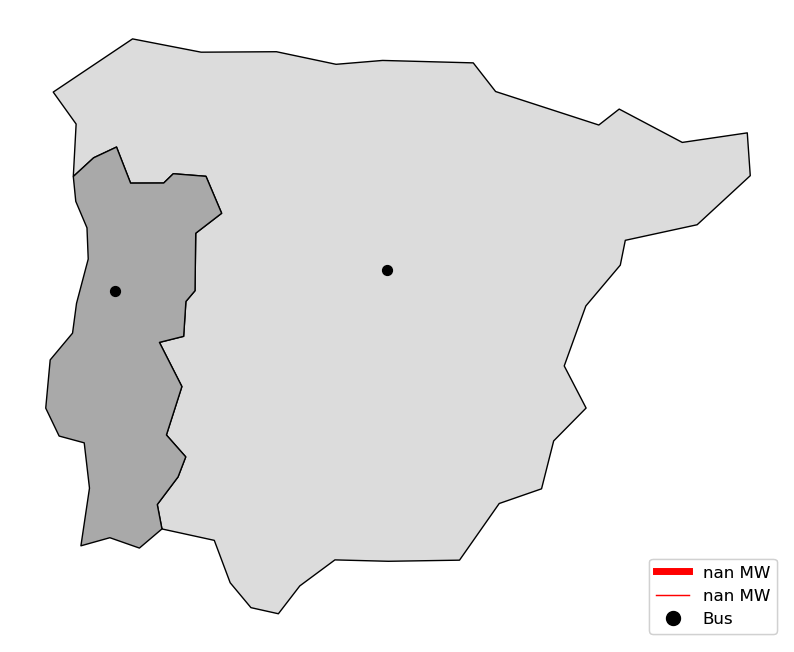

In [36]:
new_branches = branches[(branches["new"] == 1) & (branches["exists"] == 1)]
savepath = None
# savepath = os.path.join(FIGURE_FOLDER, "extended_lines.png")
plot_base_network(nodes, new_branches, savepath)

In [37]:
errors = 0
num_lines_with_errors = 0
for column in power_flow.columns[: len(power_flow.columns) // 2]:
    this_line_error = 0
    for idx in power_flow.index.values:
        if (
            power_flow.loc[idx, column] >= 0
            and power_flow.loc[idx, column + " new"] >= 0
        ):
            continue
        elif (
            power_flow.loc[idx, column] <= 0
            and power_flow.loc[idx, column + " new"] <= 0
        ):
            continue
        else:
            errors += 1
            # print(f"Branch: {column}, timestep = {idx}")
            # print(power_flow.loc[idx, column])
            # print(power_flow.loc[idx, column + " new"])
            # print("")
            this_line_error += 1
    if this_line_error > 0:
        num_lines_with_errors += 1
if errors > 0:
    print(
        f"WARNING, CHECK FOR Errors: {errors}, the number of times the same branch has different signs in the old and new branches"
    )
    print(f"Number of lines with errors: {num_lines_with_errors}")

In [38]:
combined_branches = branches.copy(deep=True)
new_indexes = branches[
    [
        True if endswith == True else False
        for endswith in branches.index.str.endswith("new")
    ]
].index
# print(new_indexes)
# Keep only the new branches
combined_branches = combined_branches.loc[new_indexes]
# print(combined_branches)
combined_branches["p_max"] = (
    combined_branches["p_max"] + combined_branches["new_capacity"]
)
combined_branches["add_on"] = np.where(combined_branches["new_capacity"] > 0, 1, 0)
combined_branches.index = combined_branches.index.str.replace(" new", "")
# print(combined_branches[["p_max", "new_capacity", "add_on"]])

In [39]:
# Make sure power flow is + if branch doesn't exist
for branch in branches[branches["exists"] == 0].index:
    if power_flow[branch].abs().sum() != 0:
        print(f"WARNING: Branch {branch} has power flow when it doesn't exist")

In [40]:
# Normalize column names in power_flow by removing " new" to group new and existing flows
normalized_columns = power_flow.columns.str.replace(" new", "", regex=False)

# Group columns by their normalized names and sum them
aggregated_power_flow = power_flow.groupby(normalized_columns, axis=1).sum()
aggregated_power_flow = aggregated_power_flow[
    [str(branch) for branch in branches.index if not str(branch).endswith("new")]
]

C:\Users\tinus\AppData\Local\Temp\ipykernel_7984\3344048242.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  aggregated_power_flow = power_flow.groupby(normalized_columns, axis=1).sum()


In [41]:
# Calculate congestion rate for each branch
p_max_normalized = branches.set_index(branches.index.astype(str))["p_max"].reindex(
    normalized_columns.unique()
)
# Calculate the congestion, congestion limit sets the threshold for calling it a congestion
congestion_limit = 0.98
congestion = aggregated_power_flow.abs() > (congestion_limit * p_max_normalized)
# Calculate the congestion rate: number of congested timesteps / total timesteps
congestion_rate = congestion.sum() / len(aggregated_power_flow)

# Create a DataFrame for results
congestion_rate_df = pd.DataFrame({"congestion_rate": congestion_rate})

In [42]:
congestion_rate_df

,congestion_rate
35,0.000114


In [43]:
absolute_aggregated_power_flow = aggregated_power_flow.abs()

In [44]:
average_used_capacity_combined_branches = absolute_aggregated_power_flow.mean(axis=0)
(average_used_capacity_combined_branches.sum() / combined_branches["p_max"].sum())

0.49812329499277547

In [45]:
print(f"Number of new branches built: {num_new_branches_built}")
print(f"Total capacity of new branches built: {total_capacity_built:.2f}")
print(
    f"Utilization of old branches: {sum(average_used_capacity_old_branches) / branch_capacity_old_branches * 100:.2f} %"
)
if branch_capacity_new_branches > 0:
    print(
        f"Utilization of new branches: {sum(average_used_capacity_new_branches) / branch_capacity_new_branches * 100:.2f} %"
    )
print(
    f"Utilization of combined branches: {(average_used_capacity_combined_branches.sum() / combined_branches["p_max"].sum())
 * 100:.2f} %"
)
print(f"Average congestion rate: {congestion_rate.mean() * 100:.2f} %")

Number of new branches built: 0
Total capacity of new branches built: 0.00
Utilization of old branches: 49.81 %
Utilization of combined branches: 49.81 %
Average congestion rate: 0.01 %


In [46]:
# Creating DataFrame with lowercase column names and no rounding
branches_overview = pd.DataFrame(
    [
        {
            "new_branches": num_new_branches_built,
            "new_capacity_mw": total_capacity_built,
            "util_old_%": (
                sum(average_used_capacity_old_branches) / branch_capacity_old_branches
            )
            * 100,
            "util_new_%": (
                (sum(average_used_capacity_new_branches) / branch_capacity_new_branches)
                * 100
                if branch_capacity_new_branches > 0
                else None
            ),
            "util_combined_%": (
                average_used_capacity_combined_branches.sum()
                / combined_branches["p_max"].sum()
            )
            * 100,
            "congestion_%": congestion_rate.mean() * 100,
        }
    ]
).dropna(
    axis=1
)  # Remove None columns if new branches don't exist

# Display DataFrame
branches_overview

,new_branches,new_capacity_mw,util_old_%,util_combined_%,congestion_%
0,0,0,49.812329,49.812329,0.011416


Plotting the network with congestion rates...
Plotting congestion network for congestion


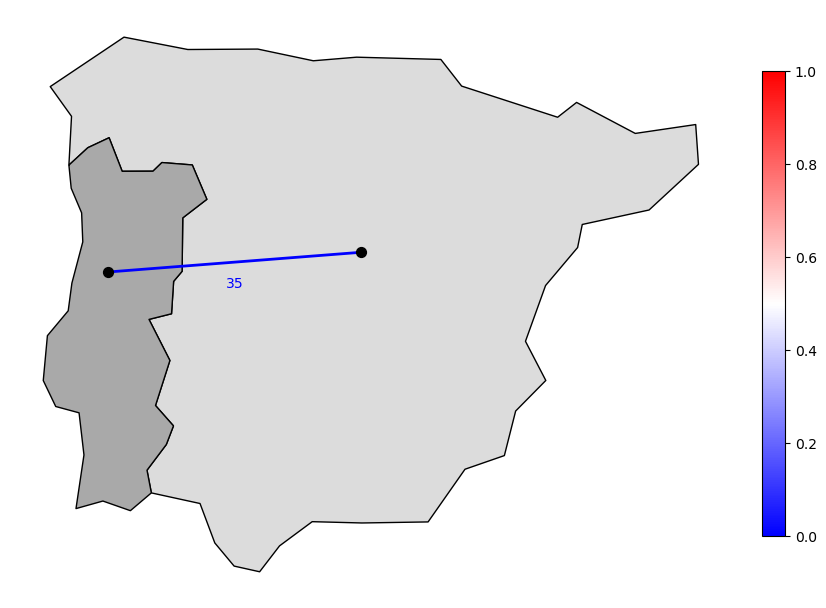

In [47]:
savepath = None
# savepath = os.path.join(FIGURE_FOLDER, "congestion_network.png")

print("Plotting the network with congestion rates...")
plotting.plot_congestion_network(
    nodes, combined_branches, congestion_rate, plot_line_numbers=True, type="congestion"
)

Plotting the network with utilization rates...
Plotting congestion network for utilization


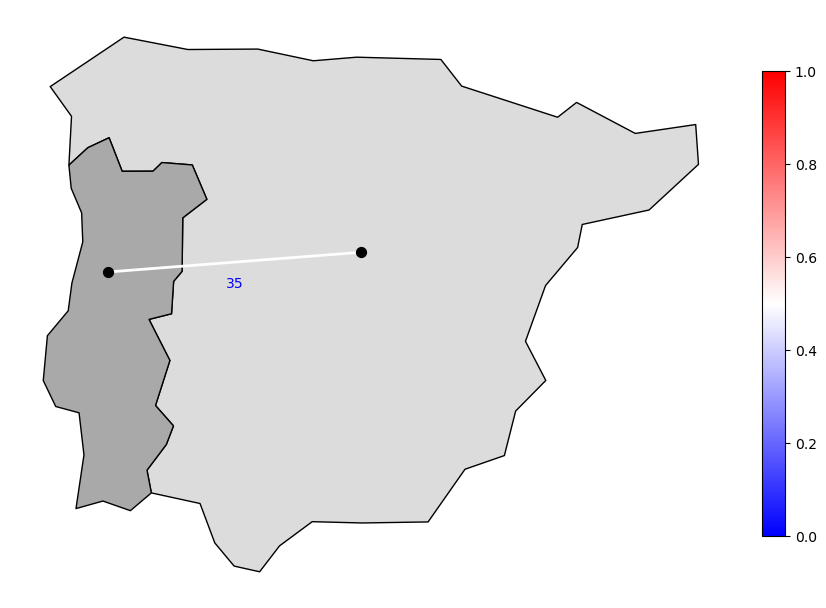

In [48]:
print("Plotting the network with utilization rates...")
# savepath = os.path.join(FIGURE_FOLDER, "utilization_network.png")
savepath = None

plotting.plot_congestion_network(
    nodes,
    combined_branches,
    average_used_capacity_combined_branches / combined_branches["p_max"],
    savepath,
    plot_line_numbers=True,
    type="utilization",
)

## Batteries analysis

In [49]:
old_battery_index_to_new = {
    battery: plotting.node_to_city[battery[:-4]] for battery in batteries.index
}

In [50]:
# 1. Rename the index in `batteries`
batteries["old_index"] = batteries.index
batteries.rename(index=old_battery_index_to_new, inplace=True)

# 2. Rename the index in `battery_build`
battery_build.rename(index=old_battery_index_to_new, inplace=True)

# 3. Rename the columns in `battery_charging`, `battery_discharging`, and `battery_soc`
battery_charging.rename(columns=old_battery_index_to_new, inplace=True)
battery_discharging.rename(columns=old_battery_index_to_new, inplace=True)
battery_soc.rename(columns=old_battery_index_to_new, inplace=True)


### Existing batteries

### Built batteries

In [51]:
if isinstance(battery_build, pd.DataFrame):
    num_batteries_built = battery_build["value"].sum()

    batteries_built = battery_build[battery_build["value"] == 1].index.values

    batteries_not_built = battery_build[battery_build["value"] == 0].index.values
else:
    num_batteries_built = 0
    batteries_not_built = []
    batteries_built = []
    num_potential_batteries = 0
num_potential_batteries = len(batteries)

potential_capacity_batteries = batteries["P_discharge_max"].sum()
potential_energy_capacity_batteries = batteries["SOC_max"].sum()

In [52]:
battery_energy_capacity_built = batteries.loc[batteries_built, "SOC_max"]
battery_power_capacity_built = batteries.loc[batteries_built, "P_discharge_max"]
print(f"Number of batteries built: {num_batteries_built}")
print(
    f"Total energy capacity of batteries built: {battery_energy_capacity_built.sum():.2f}"
)
print(
    f"Total power capacity of batteries built: {battery_power_capacity_built.sum():.2f}"
)

Number of batteries built: 2.0
Total energy capacity of batteries built: 1.80
Total power capacity of batteries built: 200000.00


In [53]:
# battery_figure_folder = os.path.join(FIGURE_FOLDER, "batteries")
# os.makedirs(battery_figure_folder, exist_ok=True)
battery_figure_folder = None

Average Hourly In-Use Pattern (State of Charge) for Each Battery


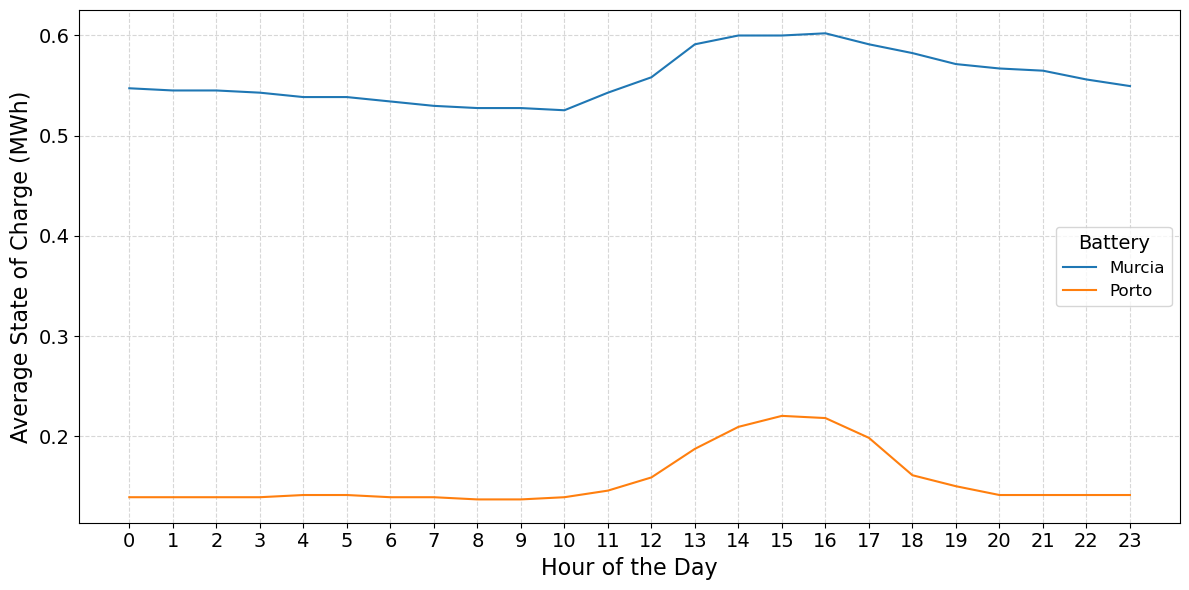

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

if isinstance(battery_soc, pd.DataFrame):
    # Extract the hour of the day from the index and group by hour
    battery_soc["hour"] = pd.to_datetime(battery_soc.index).hour
    average_hourly_soc = battery_soc.groupby("hour").mean()

    # Plot the average hourly SOC for each battery
    plt.figure(figsize=(12, 6))
    for column in battery_soc.columns[:-1]:  # Exclude the 'hour' column
        plt.plot(average_hourly_soc.index, average_hourly_soc[column], label=column)

    print("Average Hourly In-Use Pattern (State of Charge) for Each Battery")
    plt.xlabel("Hour of the Day", fontsize=16)
    plt.xticks(range(24), fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel("Average State of Charge (MWh)", fontsize=16)
    plt.legend(title="Battery", fontsize=12, title_fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    savepath = None
    # savepath = os.path.join(battery_figure_folder, "average_hourly_soc.png")
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

In [55]:
hours_per_month = 8760 / 12
days_per_month = hours_per_month / 24

In [56]:
import matplotlib.pyplot as plt


def plot_battery_soc_for_month(battery_soc, month, battery_name):
    """
    Plots the SOC for a specific battery over all timesteps in a specific month.

    Parameters:
    - battery_soc (pd.DataFrame): DataFrame containing SOC data indexed by time.
    - month (int): The month (1-12) for which to plot the SOC.
    - battery_name (str): The name of the battery to plot.

    Returns:
    - None: Displays the plot.
    """
    if not isinstance(battery_soc, pd.DataFrame):
        print("Input battery_soc must be a pandas DataFrame.")
        print("No plot")
        return

    # Add a 'month' column to simulate months for sequential data
    battery_soc["month"] = pd.to_datetime(battery_soc.index).month

    # Filter data for the specified month and battery
    filtered_data = battery_soc[battery_soc["month"] == month]
    if battery_name not in battery_soc.columns:
        print(f"Battery '{battery_name}' not found in the DataFrame columns.")
        print("No plot")
        return
    battery_soc.drop(columns=["month"], inplace=True)

    # Plot the SOC for the specified battery
    plt.figure(figsize=(12, 6))
    plt.plot(
        pd.to_datetime(filtered_data.index),
        filtered_data[battery_name],
        label=battery_name,
        color="blue",
    )
    print(f"State of Charge (SOC) for {battery_name} in Month {month}")
    plt.xlabel("Timestep", fontsize=14)
    plt.ylabel("State of Charge (SOC)", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    savepath = None
    # savepath = os.path.join(
    #     battery_figure_folder, f"battery_soc_{battery_name}_{month}.png"
    # )
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

State of Charge (SOC) for Murcia in Month 1


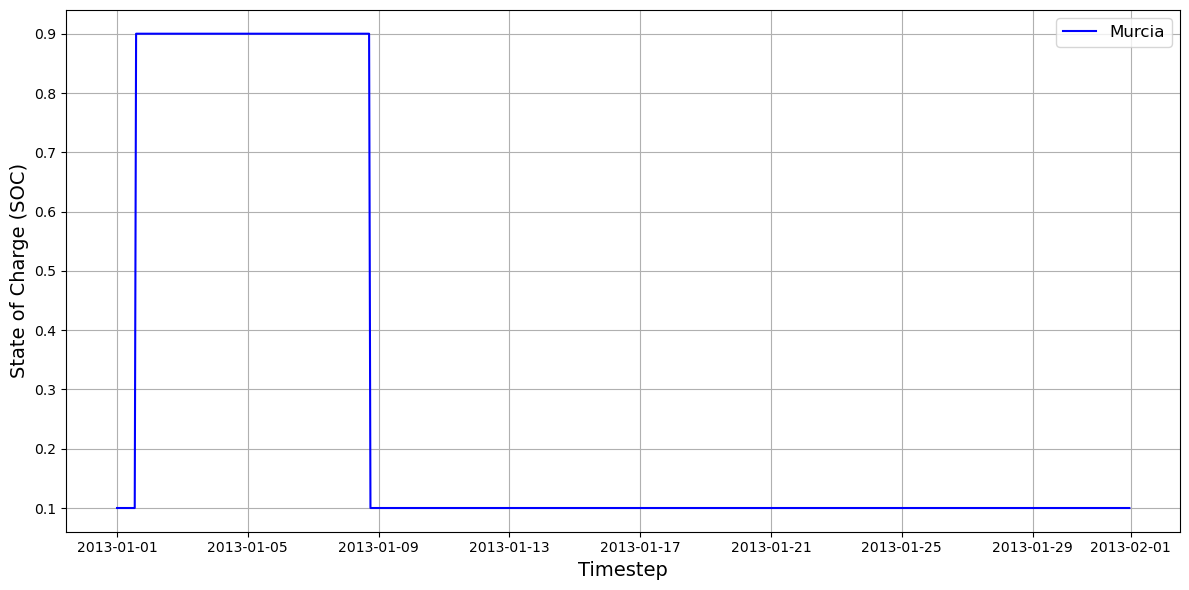

In [57]:
battery_to_check = "Murcia"
month_to_check = 1
plot_battery_soc_for_month(
    battery_soc, month=month_to_check, battery_name=battery_to_check
)

Average Hourly soc - Month 1


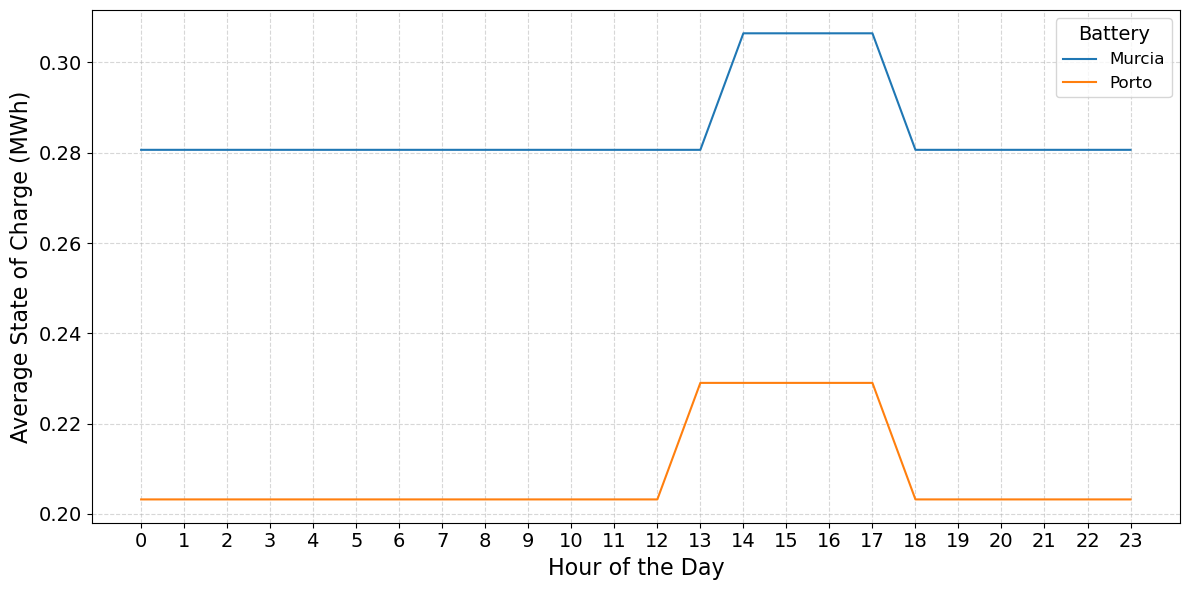

Average Hourly soc - Month 2


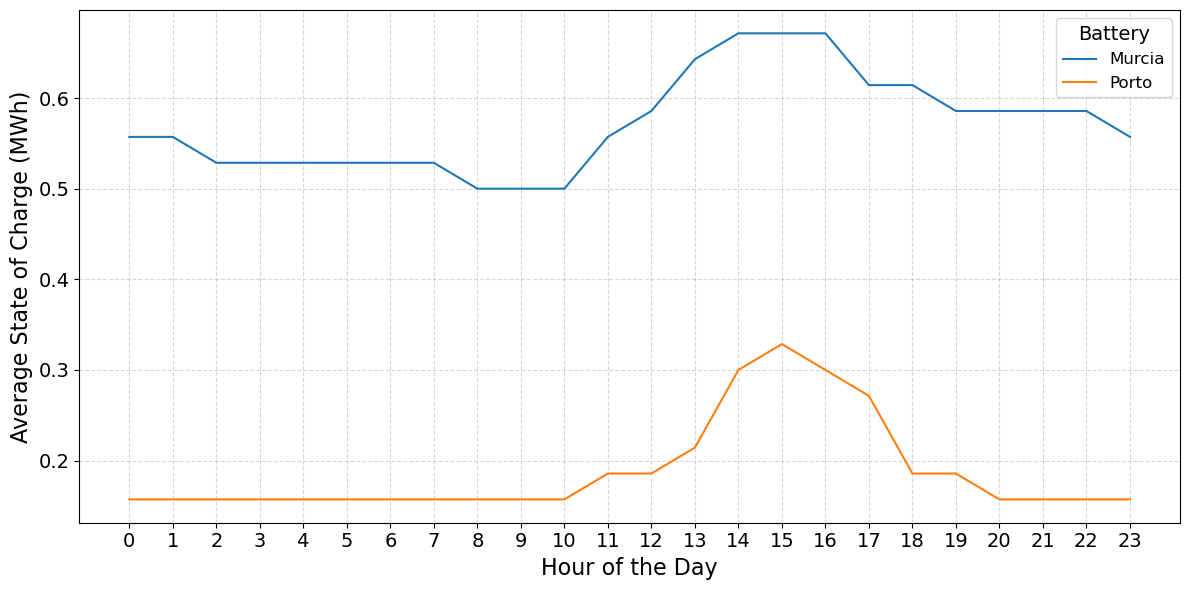

Average Hourly soc - Month 3


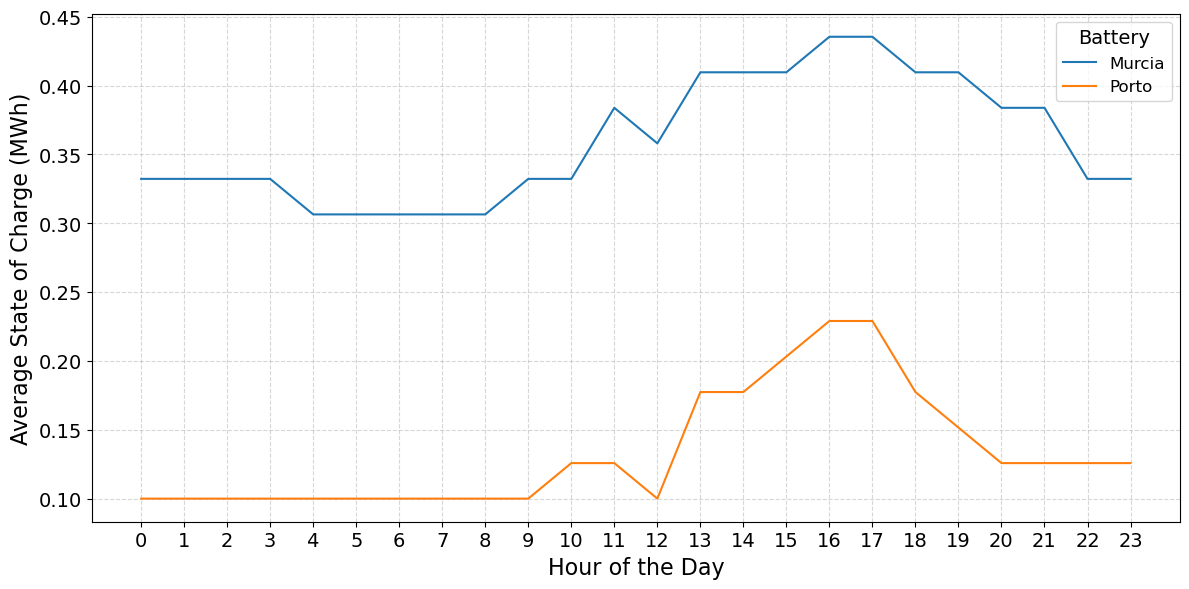

Average Hourly soc - Month 4


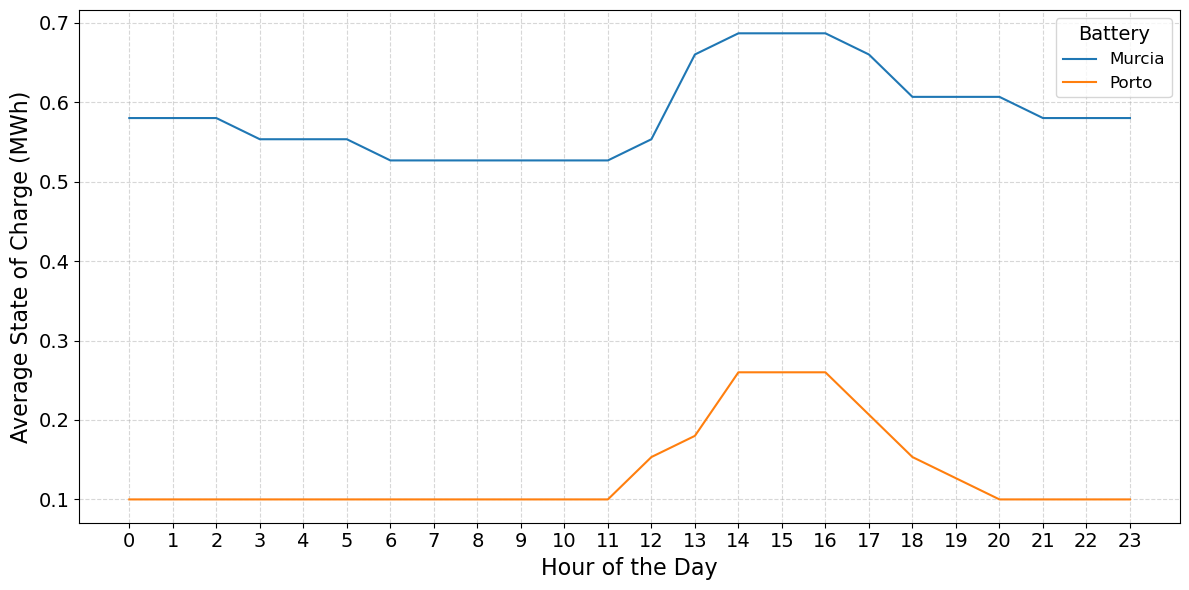

Average Hourly soc - Month 5


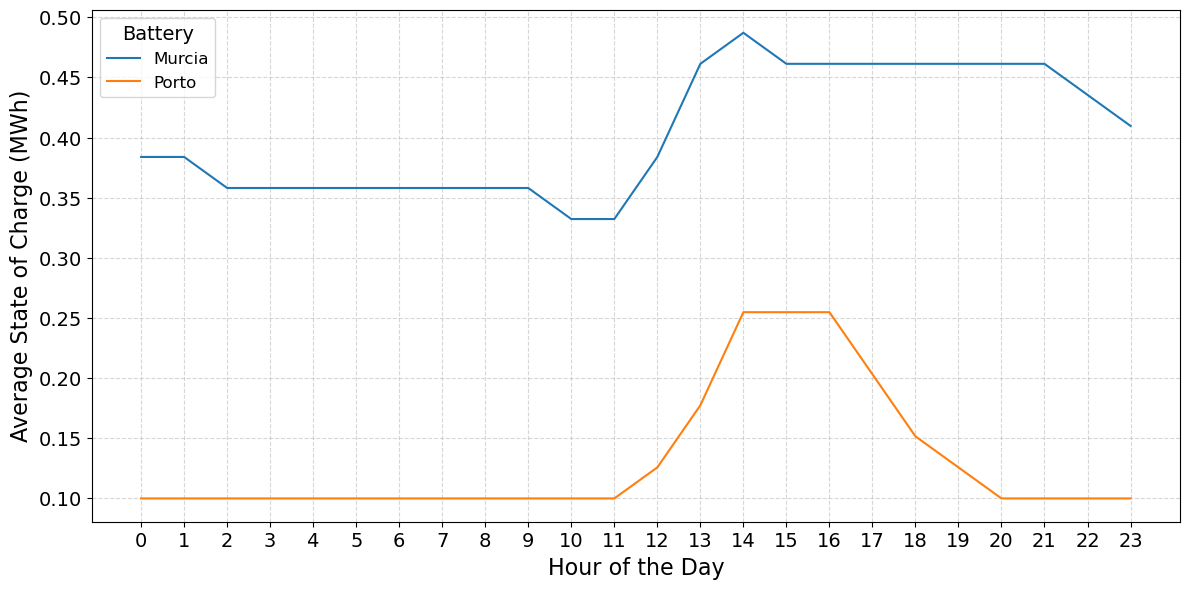

Average Hourly soc - Month 6


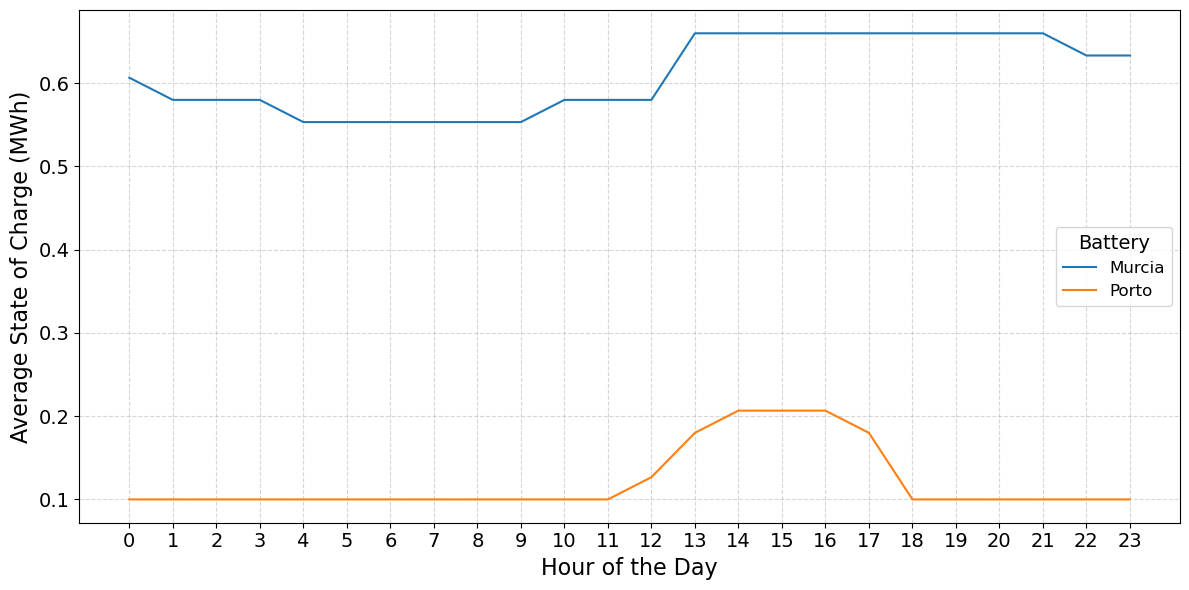

Average Hourly soc - Month 7


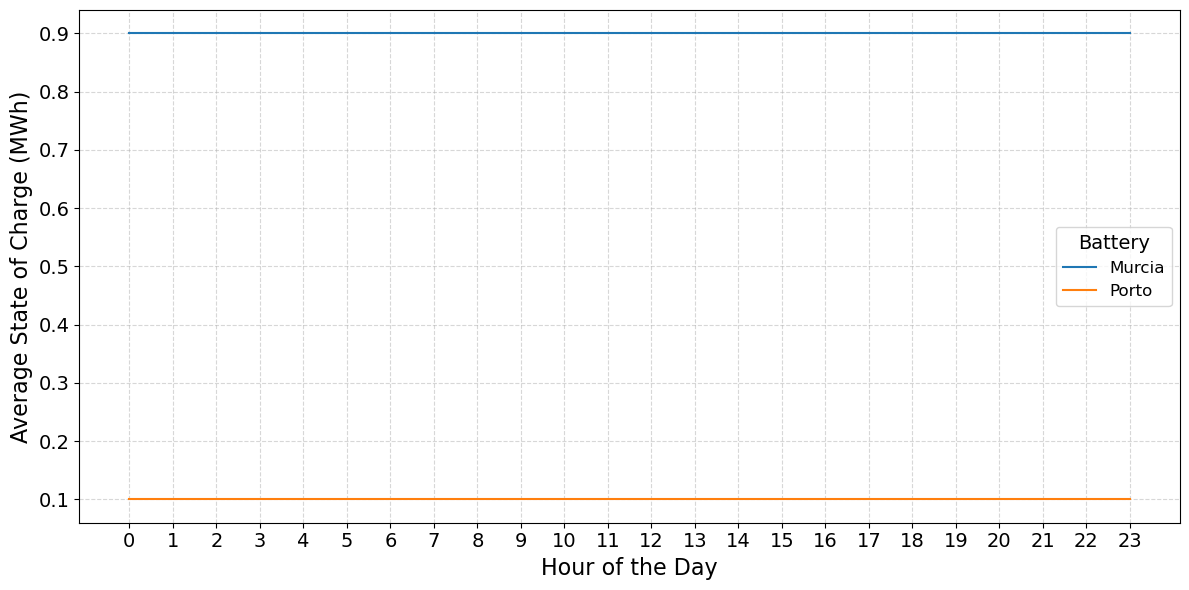

Average Hourly soc - Month 8


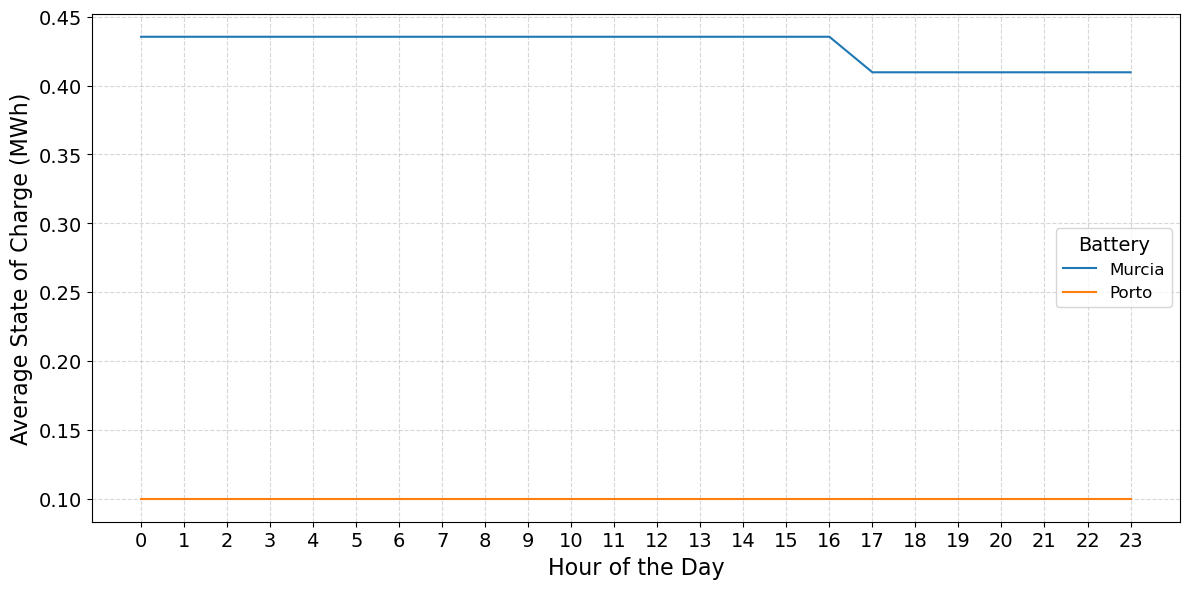

Average Hourly soc - Month 9


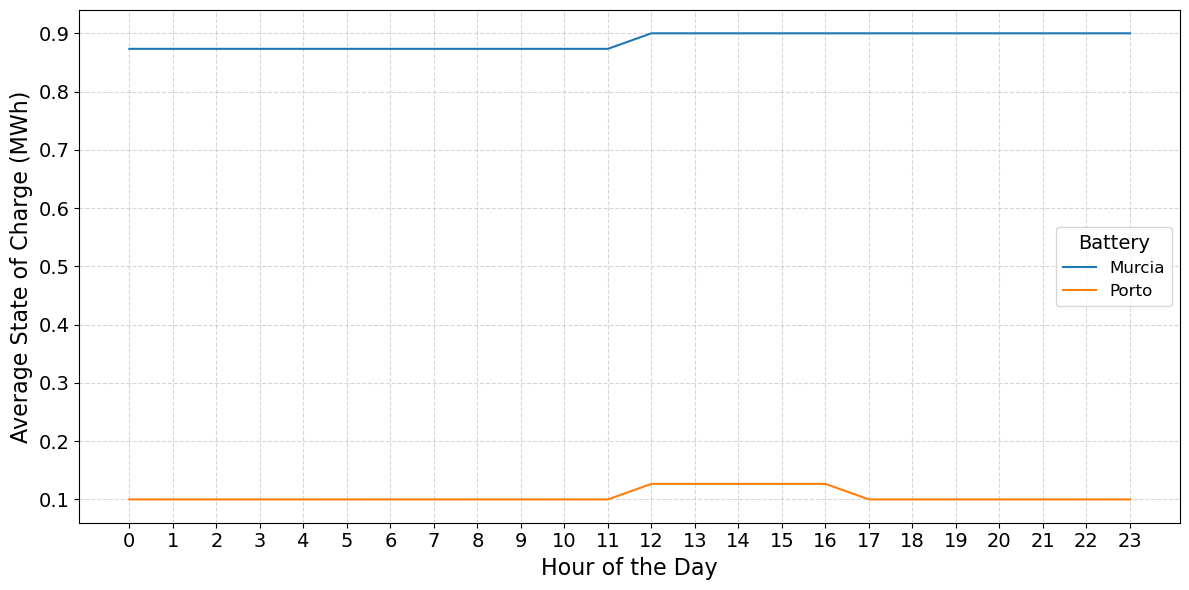

Average Hourly soc - Month 10


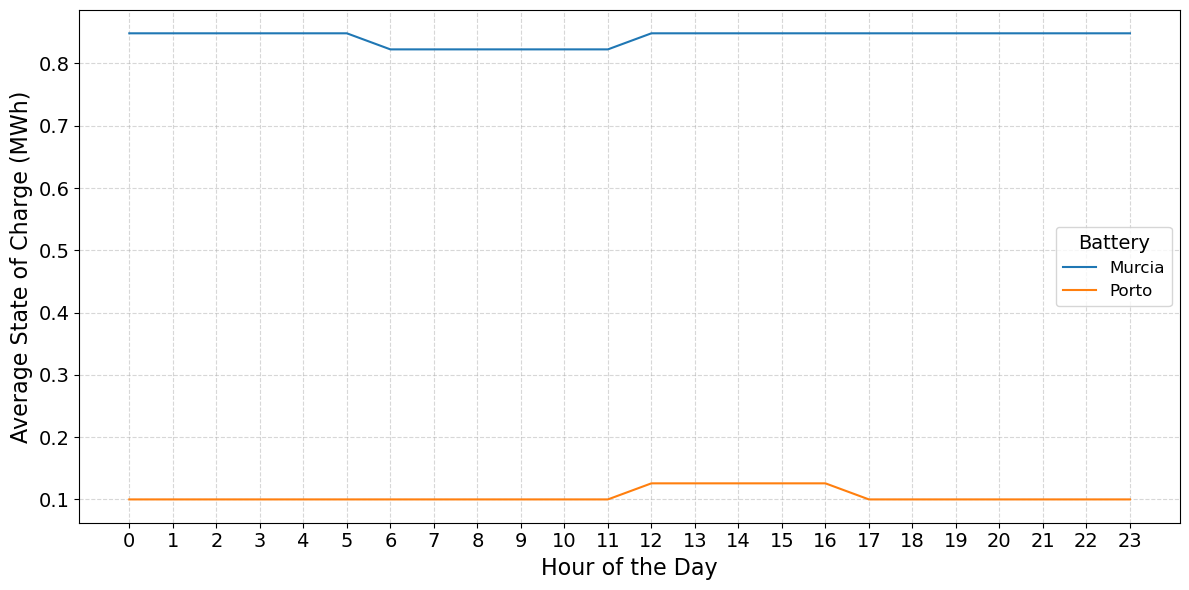

Average Hourly soc - Month 11


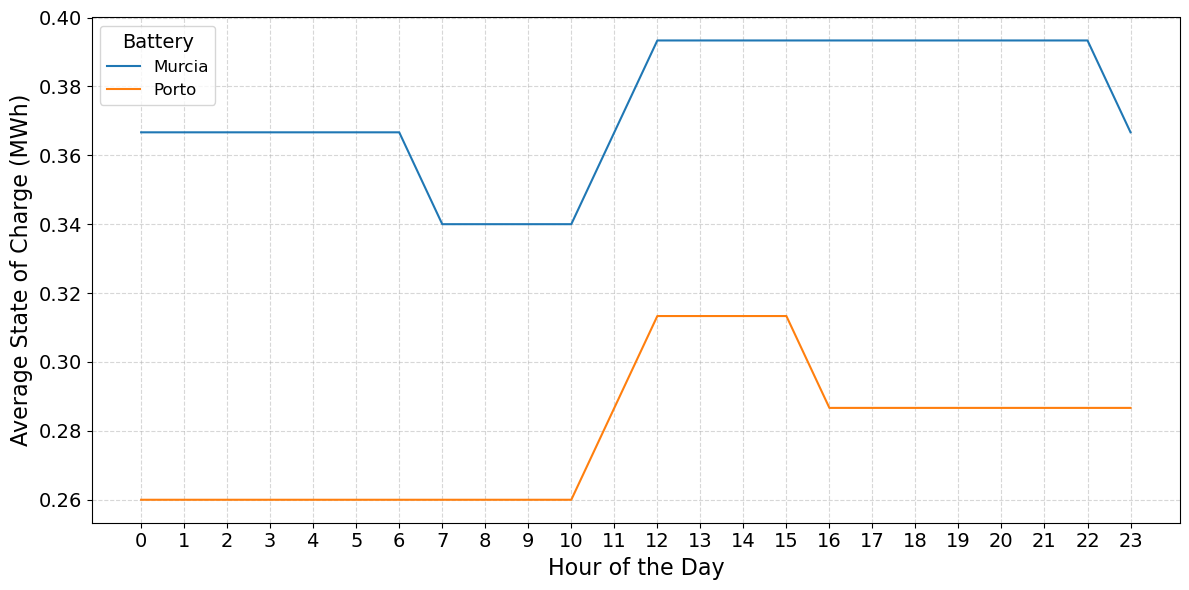

Average Hourly soc - Month 12


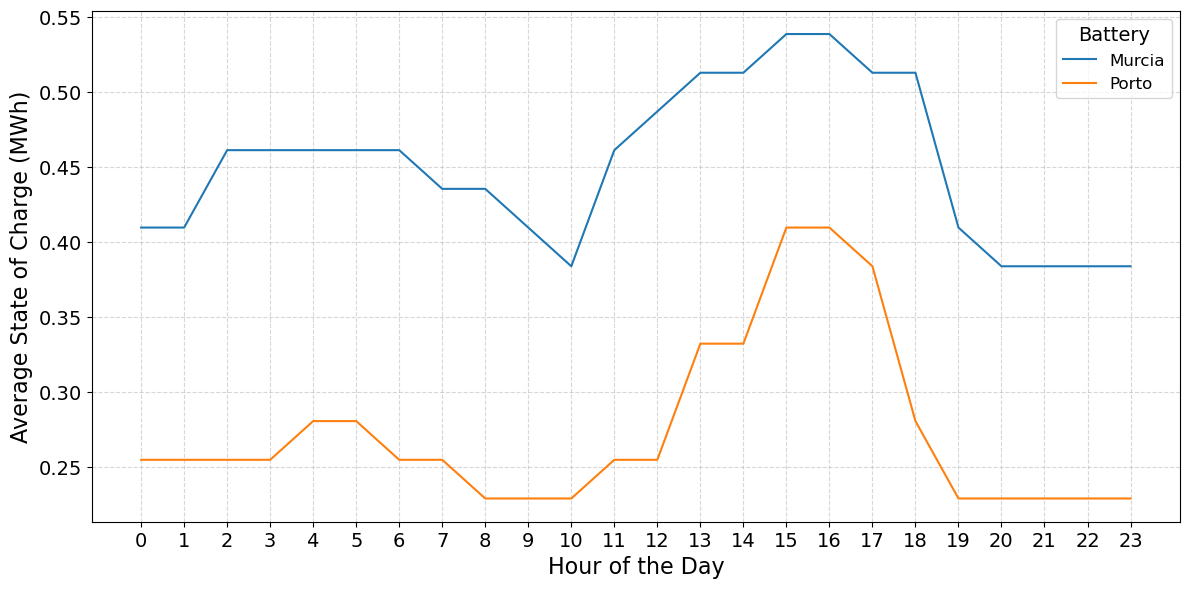

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

if isinstance(battery_soc, pd.DataFrame):

    # Ensure the 'time' index is a datetime if it's not already
    # If `time` is not already a datetime index, uncomment the line below:
    # battery_soc.index = pd.to_datetime(battery_soc.index)

    # Add 'month' and 'hour' columns
    battery_soc["month"] = pd.to_datetime(battery_soc.index).month
    battery_soc["hour"] = pd.to_datetime(battery_soc.index).hour

    # Group by hour and hour, then calculate the mean
    monthly_hourly_soc = battery_soc.groupby(["month", "hour"]).mean()

    # Create 12 plots, one for each month
    for month in range(1, 13):
        plt.figure(figsize=(12, 6))
        subset = monthly_hourly_soc.loc[month]  # Select data for the current month
        for column in battery_soc.columns[:-2]:  # Exclude 'month' and 'hour' columns
            plt.plot(subset.index, subset[column], label=column)

        print(f"Average Hourly soc - Month {month}")
        plt.xlabel("Hour of the Day", fontsize=16)
        plt.ylabel("Average State of Charge (MWh)", fontsize=16)
        plt.xticks(range(24), fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(title="Battery", fontsize=12, title_fontsize=14)
        plt.grid(True, linestyle="--", alpha=0.5)

        plt.tight_layout()
        savepath = None
        # savepath = os.path.join(
        #     battery_figure_folder, f"average_hourly_soc_month_{month}.png"
        # )
        if savepath:
            plt.savefig(savepath, bbox_inches="tight")
        plt.show()

Average Hourly In-Use Pattern for Murcia


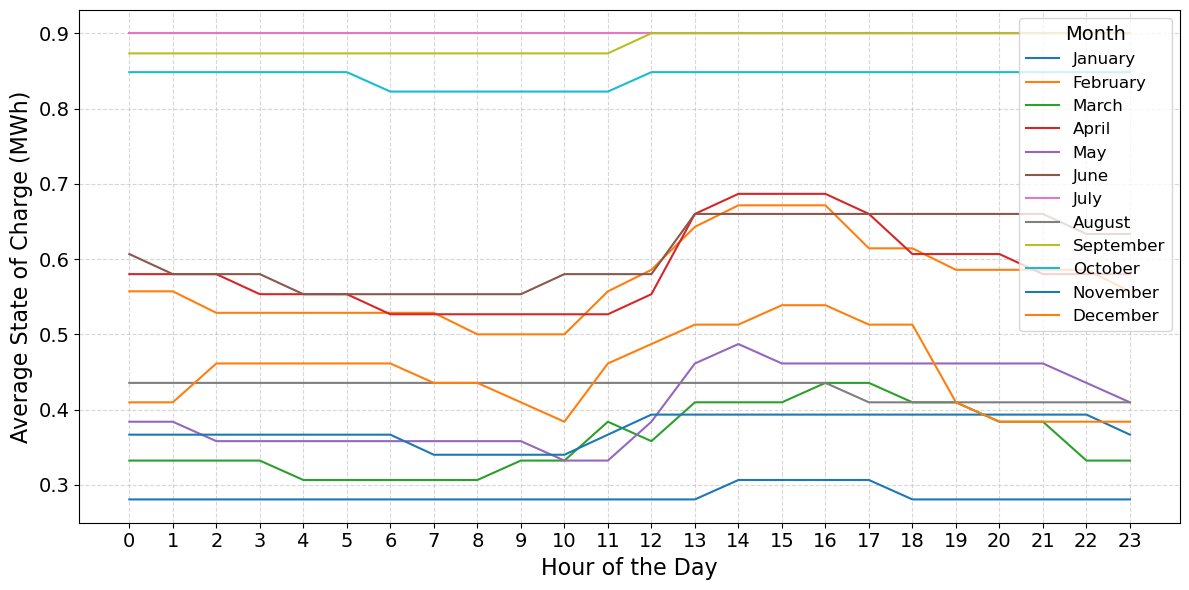

Average Hourly In-Use Pattern for Porto


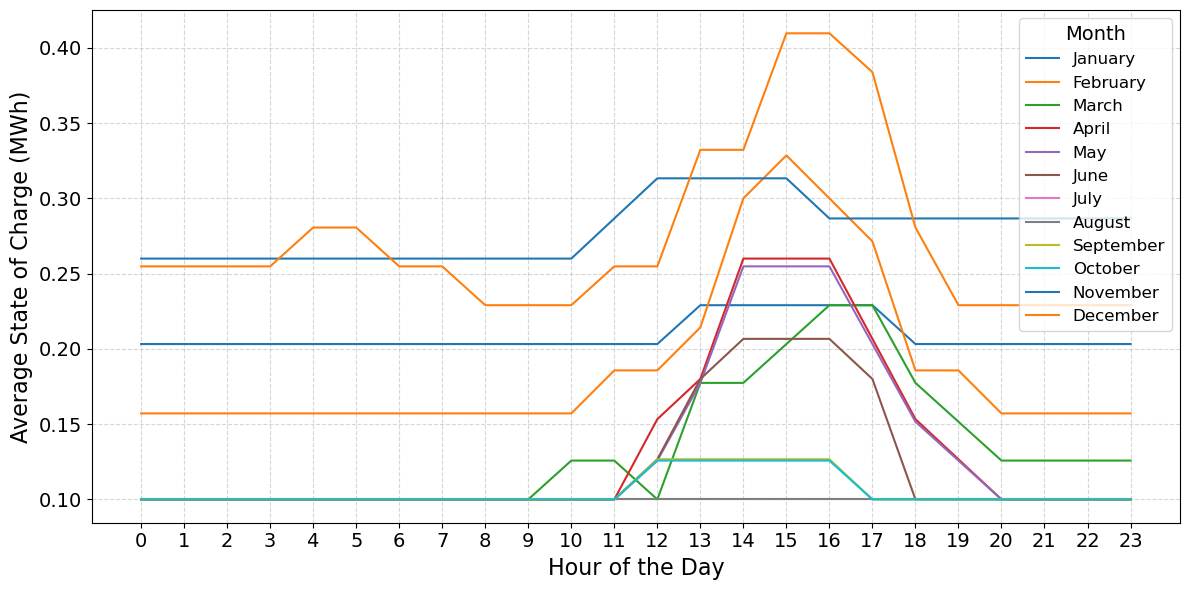

In [59]:
import pandas as pd
import matplotlib.pyplot as plt


if isinstance(battery_soc, pd.DataFrame):
    # Ensure the 'time' index is a datetime if it's not already
    # If `time` is not already a datetime index, uncomment the line below:
    # battery_soc.index = pd.to_datetime(battery_soc.index)

    # Add 'month' and 'hour' columns
    battery_soc["month"] = pd.to_datetime(battery_soc.index).month
    battery_soc["hour"] = pd.to_datetime(battery_soc.index).hour

    # Group by month and hour, then calculate the mean
    monthly_hourly_soc = battery_soc.groupby(["month", "hour"]).mean()

    # Mapping month numbers to names
    month_names = [
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ]

    # Create a plot for each battery
    for battery in battery_soc.columns[:-2]:  # Exclude 'month' and 'hour' columns
        plt.figure(figsize=(12, 6))
        for month in range(1, 13):
            # Select data for the current month
            subset = monthly_hourly_soc.loc[month]
            plt.plot(subset.index, subset[battery], label=month_names[month - 1])

        print(f"Average Hourly In-Use Pattern for {battery}")
        plt.xlabel("Hour of the Day", fontsize=16)
        plt.xticks(range(24), fontsize=14)
        plt.ylabel("Average State of Charge (MWh)", fontsize=16)
        plt.yticks(fontsize=14)
        plt.legend(title="Month", loc="upper right", fontsize=12, title_fontsize=14)
        plt.grid(True, linestyle="--", alpha=0.5)

        plt.tight_layout()
        savepath = None
        # savepath = os.path.join(
        #     battery_figure_folder, f"battery_{battery}_monthly_soc.png"
        # )
        if savepath:
            plt.savefig(savepath, bbox_inches="tight")
        plt.show()

Number of Cycles per Battery per Month


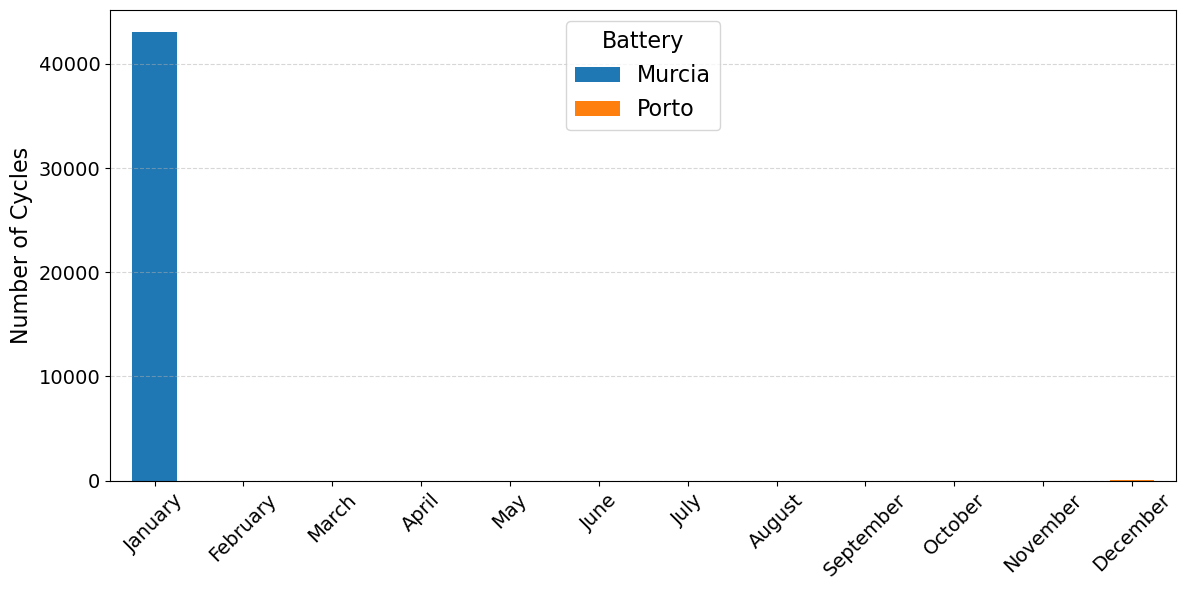

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

if isinstance(battery_discharging, pd.DataFrame):

    # Example: If the `batteries` DataFrame is not indexed by the battery names, ensure it is:
    # batteries.set_index('Battery', inplace=True)

    # Align columns in `battery_discharging` with `batteries` index
    soc_max = batteries["SOC_max"]

    # Add 'month' column to `battery_discharging`
    battery_discharging["month"] = pd.to_datetime(battery_discharging.index).month

    # Calculate cumulative discharge and cycles
    discharge_per_month = battery_discharging.groupby("month").sum()
    monthly_cycles = discharge_per_month.div(soc_max, axis=1)

    month_names = [
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ]
    monthly_cycles.index = month_names  # Replace month numbers with names

    # Plot the stacked bar chart
    monthly_cycles.plot(kind="bar", stacked=True, figsize=(12, 6))

    print("Number of Cycles per Battery per Month")
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel("Number of Cycles", fontsize=16)
    ncol = len(monthly_cycles.columns) // 3
    ncol = 1 if ncol == 0 else ncol
    plt.legend(
        title="Battery",
        title_fontsize=16,
        loc="upper center",
        fontsize=16,
        ncol=ncol,
    )
    plt.tight_layout()
    plt.grid(True, linestyle="--", alpha=0.5, axis="y")

    savepath = None
    # savepath = os.path.join(battery_figure_folder, "monthly_cycles.png")
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

C:\Users\tinus\AppData\Local\Temp\ipykernel_7984\1207606199.py:76: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend(


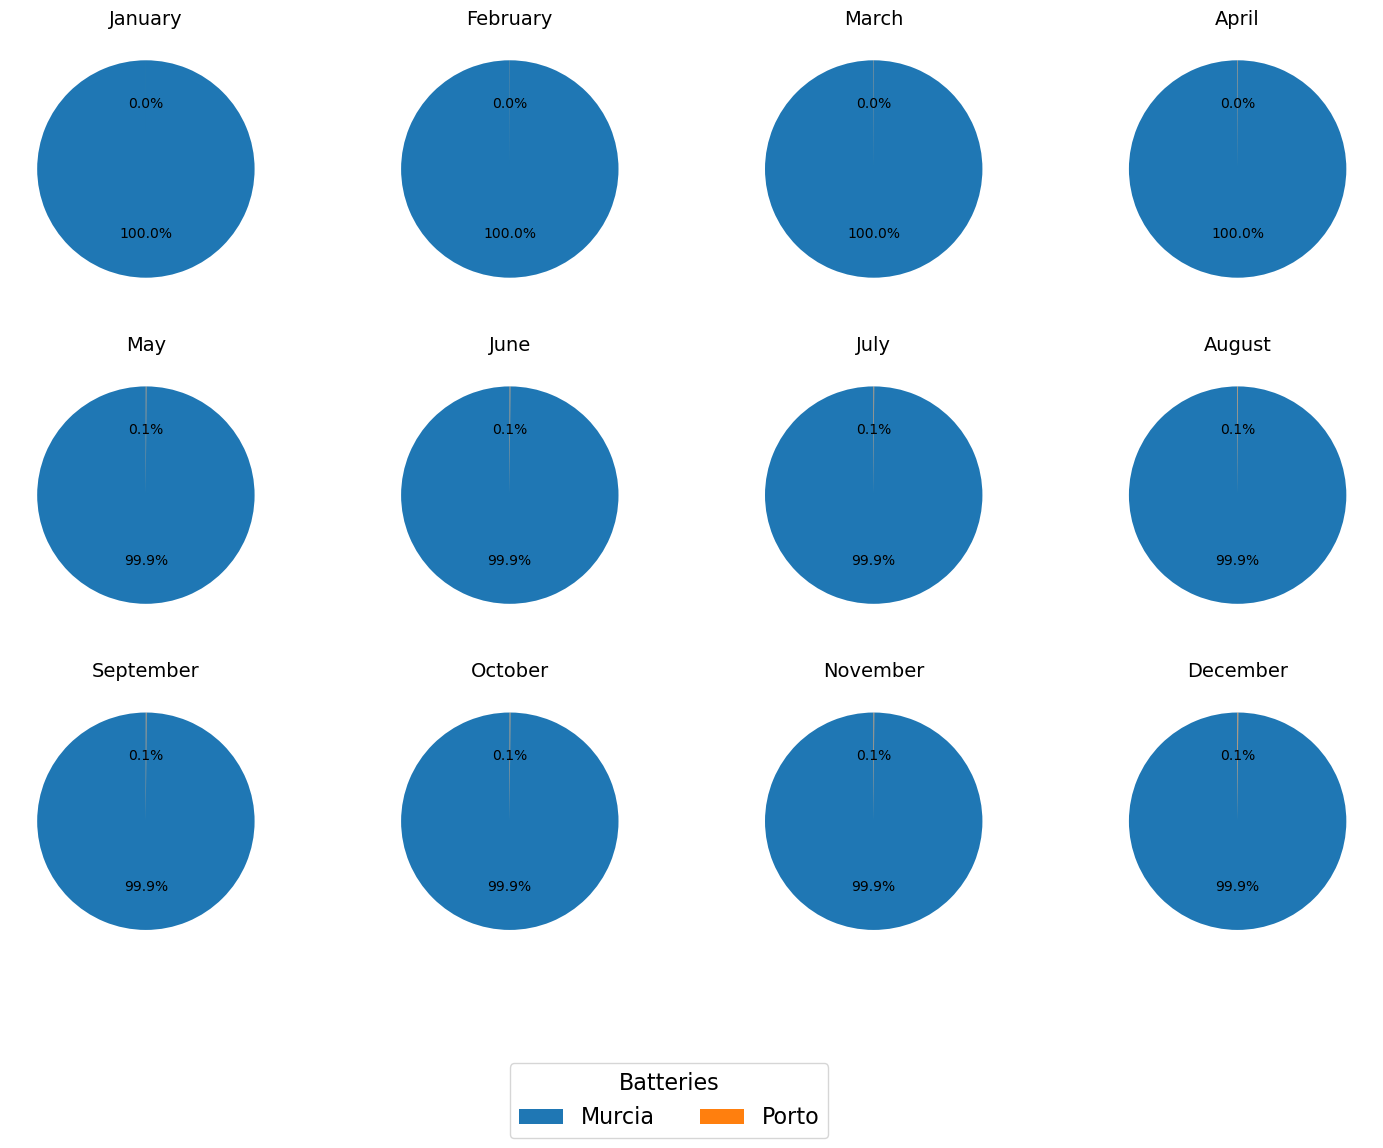

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

if isinstance(battery_discharging, pd.DataFrame):

    # Ensure `batteries` is indexed by battery names
    soc_max = batteries["SOC_max"]

    # Add 'month' column to `battery_discharging`
    battery_discharging["month"] = pd.to_datetime(battery_discharging.index).month

    # Calculate cumulative discharge and cycles
    cumulative_discharge = battery_discharging.cumsum()
    cycles = cumulative_discharge / soc_max

    # Calculate the number of cycles per month
    monthly_cycles = cycles.groupby(battery_discharging["month"]).max()
    monthly_cycles.drop(columns=["month"], inplace=True)
    battery_discharging.drop(columns=["month"], inplace=True)

    # Map month numbers to month names
    month_names = [
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ]
    monthly_cycles.index = month_names  # Replace month numbers with names

    # Create a 3x4 subplot for the pie charts
    fig, axes = plt.subplots(3, 4, figsize=(18, 12))
    axes = axes.flatten()

    # Shared legend elements
    all_labels = monthly_cycles.columns
    shared_patches = None

    for i, month in enumerate(month_names):
        ax = axes[i]
        data = monthly_cycles.loc[month]

        # Drop NaN values or replace them with 0
        data = data.fillna(0)

        # Skip if all values are zero
        if data.sum() == 0:
            ax.text(0.5, 0.5, "No Data", fontsize=16, ha="center", va="center")
            ax.axis("off")
            continue

        # Create pie chart for the current subplot
        wedges, texts, autotexts = ax.pie(
            data,
            labels=None,  # Disable labels for individual plots
            autopct="%1.1f%%",
            startangle=90,
            textprops={"fontsize": 10},
        )
        ax.set_title(month, fontsize=14)

        # Store patches for shared legend
        if shared_patches is None:
            shared_patches = wedges

    # Add a shared legend
    fig.legend(
        shared_patches,
        labels=all_labels,
        title="Batteries",
        title_fontsize=16,
        loc="lower center",
        fontsize=16,
        ncol=len(all_labels) // 2 + 1,
        bbox_to_anchor=(0.5, -0.05),
    )

    # Adjust layout
    # plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for legend
    # savepath = os.path.join(battery_figure_folder, "monthly_cycles_subplot.png")
    # plt.savefig(savepath, bbox_inches="tight")
    # plt.show()

# Macro results

In [62]:
model_info_path = r"C:\Users\tinus\OneDrive\Dokumenter\0 Master\code\master_project\runs\single_runs\GTSEP_v0-test small-Feb11_Tue_h10\model_info\model_info.csv"
model_info = pd.read_csv(model_info_path)

In [63]:
model_info

,Objective Value,Optimality Gap (%),Runtime (s),Build Time (s),Optimize Time (s),Total Time (s),Number of Variables,Number of Constraints,Number of Nonzeros,Model Status
0,1.237373e+10,0.000284,6.293,27.402521,6.428374,33.830895,297856,332889,840964,2


In [64]:
combined_df

,Built Generators,Potential Generators,Capacity,Potential Capacity
carrier,,,,
CCGT,2.0,2,12398.922259,60900.664000
solar,2.0,2,25414.038546,25414.038546
onwind,NaN,2,0.000000,64079.006689


In [65]:
num_generators_built = built_generators_by_carrier.sum()
total_generators_capacity_built = combined_df["Capacity"].sum()
num_potential_generators = len(generators) / 2
num_potential_transmission_lines = len(branches) / 2

In [67]:
print(
    f"Objective value: {model_info.loc[:,"Objective Value"].values[0] / 1e9:.2f} Billion Euro"
)


print(f"Generators built: {num_generators_built} / {num_potential_generators:.0f}")


print(f"Total capacity of generators built: {total_generators_capacity_built:.0f} MW")
print(
    f"Number of transmission lines expanded: {num_new_branches_built} / {num_potential_transmission_lines:.0f}"
)


print(f"Total capacity of new transmission lines: {total_capacity_built:.0f} MW")
print(
    f"Number of batteries built: {num_batteries_built:.0f} / {num_potential_batteries:.0f}"
)
print(
    f"Total energy capacity of batteries built: {battery_energy_capacity_built.sum():.0f} MWh"
)
print(
    f"Total power capacity of batteries built: {battery_power_capacity_built.sum():.0f} MW"
)


print(f"Total load shedding: {load_shedding.sum().sum():.0f} MWh")


print(f"Total curtailment: {curtailment.sum().sum():.0f} MWh")

Objective value: 12.37 Billion Euro
Generators built: 4 / 6
Total capacity of generators built: 37813 MW
Number of transmission lines expanded: 0 / 1
Total capacity of new transmission lines: 0 MW
Number of batteries built: 2 / 2
Total energy capacity of batteries built: 2 MWh
Total power capacity of batteries built: 200000 MW
Total load shedding: 9705 MWh
Total curtailment: 0 MWh


In [85]:
batteries

,node,MC,annualized_cost,P_discharge_max,P_discharge_min,P_charge_max,P_charge_min,SOC_max,SOC_min,delta,eta_charge,eta_discharge,exists,old_index
Battery,,,,,,,,,,,,,,
Murcia,ES1 0,0,21958.92494,100000,0,100000,0,0.9,0.1,0.000042,0.98,0.97,0,ES1 0 bat
Porto,PT1 0,0,21958.92494,100000,0,100000,0,0.9,0.1,0.000042,0.98,0.97,0,PT1 0 bat


In [68]:
data = {
    "Objective Value (Billion Euro)": model_info.loc[:, "Objective Value"].values[0]
    / 1e9,
    "Generators Built": f"{num_generators_built} / {num_potential_generators}",
    "Total Generator Capacity (MW)": total_generators_capacity_built,
    "Transmission Lines Expanded": f"{num_new_branches_built} / {num_potential_transmission_lines}",
    "Total Transmission Capacity (MW)": total_capacity_built,
    "Batteries Built": f"{num_batteries_built} / {num_potential_batteries}",
    "Total Battery Energy Capacity (MWh)": battery_energy_capacity_built.sum(),
    "Total Battery Power Capacity (MW)": battery_power_capacity_built.sum(),
    "Total Load Shedding (MWh)": load_shedding.sum().sum(),
    "Total Curtailment (MWh)": curtailment.sum().sum(),
}

df = pd.DataFrame([data])
df

,Objective Value (Billion Euro),Generators Built,Total Generator Capacity (MW),Transmission Lines Expanded,Total Transmission Capacity (MW),Batteries Built,Total Battery Energy Capacity (MWh),Total Battery Power Capacity (MW),Total Load Shedding (MWh),Total Curtailment (MWh)
0,12.373727,4 / 6.0,37812.960805,0 / 1.0,0,2.0 / 2,1.8,200000,9704.573902,0.0


In [69]:
generators["new_capacity"].sum()

37812.96080534752

## Cost breakdown

In [70]:
generators["cost_of_buildout"] = np.where(
    (generators["new_capacity"] > 0),
    generators["new_capacity"] * generators["capital_cost"],
    0,
)
cost_of_buildout_by_carrier = generators.groupby("carrier")["cost_of_buildout"].sum()

In [71]:
carriers = generators["carrier"].unique()

In [72]:
total_production_by_carrier_old = {}
total_production_by_carrier_new = {}
total_production_cost_by_carrier = {}
total_co2_emissions_cost_by_carrier = {}
for carrier in carriers:
    carrier_columns = [col for col in generation.columns if col.endswith(carrier)]
    total_production_by_carrier_old[carrier] = generation[carrier_columns].sum().sum()
    total_production_cost = (
        (generation[carrier_columns] * generators.loc[carrier_columns, "marginal_cost"])
        .sum()
        .sum()
    )
    total_co2_emissions_cost = (
        (generation[carrier_columns] * generators.loc[carrier_columns, "co2_emissions"])
        .sum()
        .sum()
    ) * model_config["CO2_price"]
    new_carrier_columns = [
        col for col in generation.columns if col.endswith(f"{carrier} new")
    ]
    total_production_by_carrier_new[carrier] = (
        generation[new_carrier_columns].sum().sum()
    )
    total_production_cost_by_carrier[carrier] = (
        total_production_cost
        + (
            generation[new_carrier_columns]
            * generators.loc[new_carrier_columns, "marginal_cost"]
        )
        .sum()
        .sum()
    )
    total_co2_emissions_cost_by_carrier[carrier] = (
        total_co2_emissions_cost
        + (
            generation[new_carrier_columns]
            * generators.loc[new_carrier_columns, "co2_emissions"]
        )
        .sum()
        .sum()
        * model_config["CO2_price"]
    )

In [73]:
total_production_by_carrier = {
    key: total_production_by_carrier_old[key] + total_production_by_carrier_new[key]
    for key in total_production_by_carrier_old.keys()
}

In [74]:
# Convert each dictionary to a DataFrame
df_production = pd.DataFrame.from_dict(
    total_production_by_carrier, orient="index", columns=["Total Production [MW]"]
)
df_production_new = pd.DataFrame.from_dict(
    total_production_by_carrier_new, orient="index", columns=["New Production [MW]"]
)
df_production_old = pd.DataFrame.from_dict(
    total_production_by_carrier_old, orient="index", columns=["Old Production [MW]"]
)
df_production_cost = pd.DataFrame.from_dict(
    total_production_cost_by_carrier,
    orient="index",
    columns=["Total Production Cost [€]"],
)
df_co2_emissions_cost = pd.DataFrame.from_dict(
    total_co2_emissions_cost_by_carrier,
    orient="index",
    columns=["Total CO2 Emissions Cost [€] check"],
)

# Concatenate the DataFrames
generators_df_summary = pd.concat(
    [
        df_production,
        df_production_new,
        df_production_old,
        df_production_cost,
        cost_of_buildout_by_carrier,
    ],
    axis=1,
)

# Reset the index and rename the carrier column
generators_df_summary.reset_index(inplace=True)
generators_df_summary.rename(columns={"index": "carrier"}, inplace=True)

In [75]:
marginal_cost_by_carrier = generators.groupby("carrier")["marginal_cost"].mean()
emission_per_mwh_by_carrier = generators.groupby("carrier")["co2_emissions"].mean()
generators_df_summary = pd.merge(
    generators_df_summary, marginal_cost_by_carrier, on="carrier"
)
generators_df_summary = pd.merge(
    generators_df_summary, emission_per_mwh_by_carrier, on="carrier"
)
# Set 'carrier' as the index and rename columns
generators_df_summary.set_index("carrier", inplace=True)

generators_df_summary.rename(
    columns={
        "cost_of_buildout": "Cost of Buildout [€]",
        "marginal_cost": "Marginal Cost [€/MWh]",
        "co2_emissions": "CO2 Emission Intensity [ton/MWh]",
    },
    inplace=True,
)

In [ ]:
generators_df_summary["Total Production Cost [€] old"] = (
    generators_df_summary["Total Production [MW]"]
    * generators_df_summary["Marginal Cost [€/MWh]"]
)
generators_df_summary["Total CO2 Emissions [ton]"] = (
    generators_df_summary["Total Production [MW]"]
    * generators_df_summary["CO2 Emission Intensity [ton/MWh]"]
)
generators_df_summary["Total CO2 Cost [€]"] = (
    generators_df_summary["Total CO2 Emissions [ton]"] * model_config["CO2_price"]
)
generators_df_summary["Total Production Cost With Emissions [€]"] = (
    generators_df_summary["Total Production Cost [€]"]
    + generators_df_summary["Total CO2 Cost [€]"]
)
generators_df_summary["Total Cost €"] = (
    generators_df_summary["Cost of Buildout [€]"]
    + generators_df_summary["Total Production Cost With Emissions [€]"]
)
total = generators_df_summary.sum(numeric_only=True)
generators_df_summary.loc["Total"] = total

In [86]:
generators_df_summary

,Total Production [MW],New Production [MW],Old Production [MW],Total Production Cost [€],Cost of Buildout [€],Marginal Cost [€/MWh],CO2 Emission Intensity [ton/MWh],Total Production Cost [€] old,Total CO2 Emissions [ton],Total CO2 Cost [€],Total Production Cost With Emissions [€],Total Cost €
carrier,,,,,,,,,,,,
CCGT,1.794534e+08,7.401994e+07,1.054335e+08,7.127373e+09,1.227837e+09,39.824539,0.2,7.146649e+09,3.589068e+07,3.050708e+09,1.017808e+10,1.140592e+10
onwind,5.163088e+07,0.000000e+00,5.163088e+07,7.744631e+05,0.000000e+00,0.015000,0.0,7.744631e+05,0.000000e+00,0.000000e+00,7.744631e+05,7.744631e+05
solar,5.786064e+07,3.857266e+07,1.928799e+07,5.786064e+05,9.047924e+08,0.010000,0.0,5.786064e+05,0.000000e+00,0.000000e+00,5.786064e+05,9.053710e+08
Total,2.889449e+08,1.125926e+08,1.763523e+08,7.128726e+09,2.132630e+09,39.849539,0.2,7.148002e+09,3.589068e+07,3.050708e+09,1.017943e+10,1.231206e+10


In [78]:
battery_build_cost = (
    batteries.loc[batteries_built, "annualized_cost"]
    * batteries.loc[batteries_built, "SOC_max"]
).sum()

In [79]:
branches_built = branch_build[branch_build["value"] == 1].index.values
branches_cost = branches.loc[branches_built, "capital_cost"].sum()

In [ ]:
load_shedding_cost = load_shedding.sum().sum() * float(model_config["VOLL"])
curtailment_cost = curtailment.sum().sum() * model_config["CC"]
print(f"Cost Breakdown")
print(
    f"Building generators: {generators_df_summary.loc['Total', 'Cost of Buildout [€]']:.2f} €"
)
print(f"Building transmission lines: {branches_cost:.2f} €")
print(f"Building batteries: {battery_build_cost:.2f} €")
print(
    f"Energy production cost (w/o emissions): {generators_df_summary.loc['Total', 'Total Production Cost [€]']:.2f} €"
)
print(
    f"CO2 emissions cost: {generators_df_summary.loc['Total', 'Total CO2 Cost [€]']:.2f} €"
)
print(
    f"Production cost with emissions: {generators_df_summary.loc['Total', 'Total Production Cost With Emissions [€]']:.2f} €"
)
print(f"Load shedding cost: {load_shedding_cost:.2f} €")
print(f"Curtailment cost: {curtailment_cost:.2f} €")
total_cost = (
    generators_df_summary.loc["Total", "Cost of Buildout [€]"]
    + generators_df_summary.loc["Total", "Total Production Cost [€]"]
    + generators_df_summary.loc["Total", "Total CO2 Cost [€]"]
    + branches_cost
    + battery_build_cost
    + load_shedding_cost
    + curtailment_cost
)
print(f"Total cost: {total_cost} €")

Cost Breakdown
Building generators: 2132629527.93 €
Building transmission lines: 0.00 €
Building batteries: 39526.06 €
Energy production cost (w/o emissions): 7128726135.39 €
CO2 emissions cost: 3050708003.78 €
Production cost with emissions: 10179434139.18 €
Load shedding cost: 61624044.28 €
Curtailment cost: 0.00 €
Total cost: 12373727237.44994 €


In [82]:
print(f"Total cost: {total_cost / 1e9:.2f}  Billion €")
print(f"obj: {model_info["Objective Value"].values[0]/1e9:.2f} Billion €")
print(f"diff: {total_cost - model_info['Objective Value'].values[0]:.2f}  Euro")

Total cost: 12.37  Billion €
obj: 12.37 Billion €
diff: 0.00  Euro
